In [1]:
import pandas as pd
import numpy as np

#Bibliotheques graphiques 
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

#Bibliotheque geo et math 
import math
from geopy.geocoders import Nominatim

from scipy.stats import anderson
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
import statsmodels.api as sm

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import decomposition

### Fonctions des traitements des données 

In [2]:
# fonction qui remove les colonnes 
def remove_column(df,columns):
    df.drop(labels=columns,axis=1, inplace= True)
    

In [3]:
# retires les colonnes ou les nombres des valeurs nan et superieur a 60%
def remove_column_nul(df,rate):
    cols_vides = [col for col in df.columns if df[col].isna().mean()>rate] #0.5
    df.drop(cols_vides, axis=1, inplace=True)
    plt.figure(figsize=(20,10))
    sns.heatmap(df.isna(),cbar=False)

In [4]:
def unique_object(df):
    for col in df.select_dtypes('object'):
        print(f'{col:-<50} {df[col].unique()}')

In [5]:
def knn_imputer(df,k):

    imputer = KNNImputer(n_neighbors=k)
    After_imputation = imputer.fit_transform(df)
    df = pd.DataFrame(After_imputation,columns = df.columns)

    return df

### fonction graphique

In [6]:
# fonction qui renvoi un graphe camembert  
def pie_value(df):
    fig = plt.figure(figsize=(12,8))
    sns.set_theme()
    df.value_counts().plot.pie()

In [7]:
# fonction qui renvoi la distribution par rapport aux variables 
def distplot(df):
    sns.distplot(df)

In [8]:
# fonction qui crée un ensemble des graphes par rapport aux labels 
def distplots(df,labels):
    fig = plt.figure()
    sns.set(rc = {'figure.figsize':(30,30)})
    sns.set_theme()
    for i,label in enumerate(labels):
        axes = fig.add_subplot(12,3 , i+1)
        distplot(df[label])

In [9]:
# fonction qui renvoi une boite a moustaches 
def boxplot(df):
    sns.set_theme()
    sns.boxplot(x=df,data=df)

In [10]:
# fonction qui crée un ensemble des graphes par rapport aux labels 
def boxplots(df,labels):
    fig = plt.figure()
    sns.set(rc = {'figure.figsize':(30,30)})
    sns.set_theme()
    for i,label in enumerate(labels):
        axes = fig.add_subplot(9,3 , i+1)
        boxplot(df[label])

In [11]:
# fonction qui renvoi un nuages des points 
def scatter(df,a,b):
    sns.set(rc = {'figure.figsize':(30,30)})
    sns.scatterplot(data=df, x=a, y=b)

In [12]:
# fonction qui crée un ensemble des graphes par rapport aux labels 
def scatters(df,fix_label,labels):
    fig = plt.figure()
    sns.set(rc = {'figure.figsize':(40,40)})
    sns.set_theme()
    for i,label in enumerate(labels):
        axes = fig.add_subplot(9,3 , i+1)
        scatter(df,fix_label,label)

In [13]:
def info_build(coo):
    geoLoc = Nominatim(user_agent="GetLoc") 
    locname = geoLoc.reverse(coo) 
    return locname

In [14]:
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

In [15]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [16]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(15,12))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

# Nettoyage des données

On recupere les information du dataframe

In [17]:
df=pd.read_csv('2016_Building_Energy_Benchmarking.csv')

In [18]:
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [19]:
df.shape

(3376, 46)

In [20]:
df.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
dtype: int64

On observe que notre dataframe df contient 3376 lignes et 46 variables, dans lequels 22 sont de type Float, 8 de type entier, 1 de type booleen et 15 de type object, c'est a dire que nosu avons 31 variables qualitatives et 15 variables quantitatives, dans la suite on regardera, si nos variables contient des valeurs manquantes ou des valeurs aberrants, on observera aussi s'il interessant de conserver tout les variables ainsi que leur influence sur notre problematique.

Pour commencer, on etudiera les valeurs manquantes.

In [21]:
df.isnull().mean().sort_values(ascending=False)

Comments                           1.000000
Outlier                            0.990521
YearsENERGYSTARCertified           0.964751
ThirdLargestPropertyUseType        0.823460
ThirdLargestPropertyUseTypeGFA     0.823460
SecondLargestPropertyUseType       0.502666
SecondLargestPropertyUseTypeGFA    0.502666
ENERGYSTARScore                    0.249704
LargestPropertyUseTypeGFA          0.005924
LargestPropertyUseType             0.005924
ZipCode                            0.004739
ListOfAllPropertyUseTypes          0.002666
SourceEUIWN(kBtu/sf)               0.002666
SourceEUI(kBtu/sf)                 0.002666
Electricity(kWh)                   0.002666
Electricity(kBtu)                  0.002666
NaturalGas(therms)                 0.002666
NaturalGas(kBtu)                   0.002666
TotalGHGEmissions                  0.002666
SteamUse(kBtu)                     0.002666
GHGEmissionsIntensity              0.002666
NumberofBuildings                  0.002370
SiteEUI(kBtu/sf)                

## Traitement des valeur manquants 

In [22]:
df.isnull().mean().sort_values(ascending=False)

Comments                           1.000000
Outlier                            0.990521
YearsENERGYSTARCertified           0.964751
ThirdLargestPropertyUseType        0.823460
ThirdLargestPropertyUseTypeGFA     0.823460
SecondLargestPropertyUseType       0.502666
SecondLargestPropertyUseTypeGFA    0.502666
ENERGYSTARScore                    0.249704
LargestPropertyUseTypeGFA          0.005924
LargestPropertyUseType             0.005924
ZipCode                            0.004739
ListOfAllPropertyUseTypes          0.002666
SourceEUIWN(kBtu/sf)               0.002666
SourceEUI(kBtu/sf)                 0.002666
Electricity(kWh)                   0.002666
Electricity(kBtu)                  0.002666
NaturalGas(therms)                 0.002666
NaturalGas(kBtu)                   0.002666
TotalGHGEmissions                  0.002666
SteamUse(kBtu)                     0.002666
GHGEmissionsIntensity              0.002666
NumberofBuildings                  0.002370
SiteEUI(kBtu/sf)                

<AxesSubplot:>

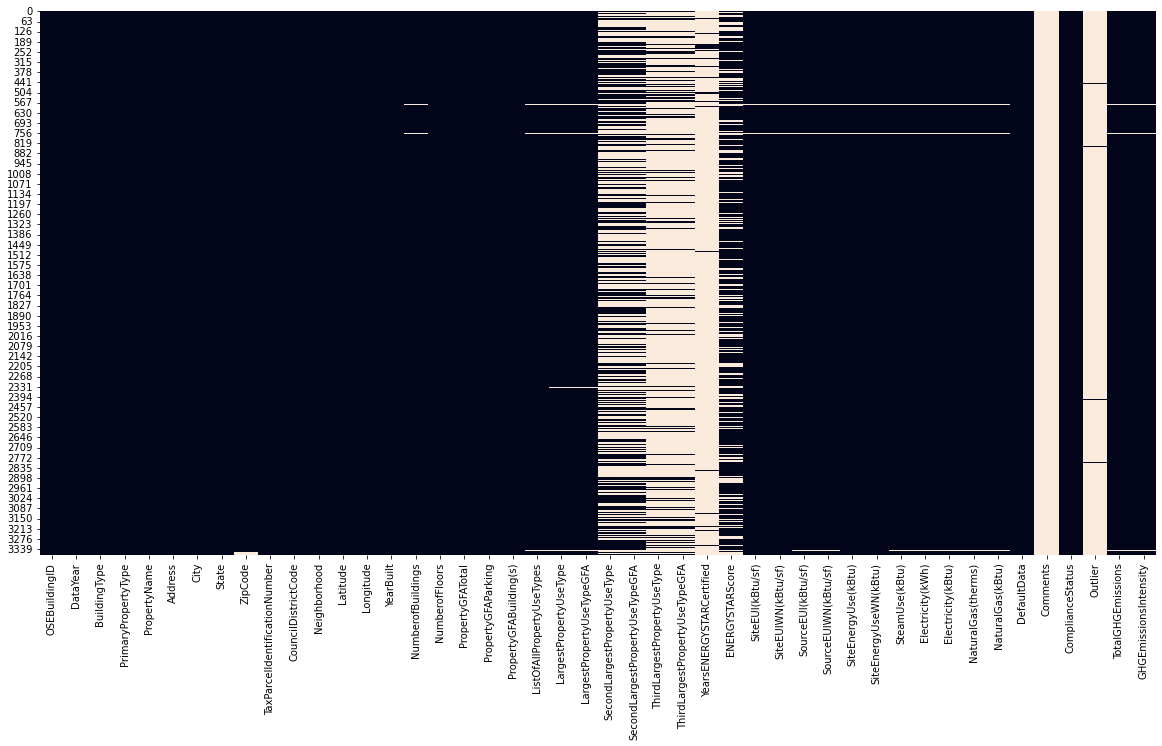

In [23]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(),cbar=False)

Ci-desssus, on remarque que notre dataframe ne contient pas beaucoup des valeurs manquantes, on peut observer trois variables qui ont plus de 90% des valeurs manquantes et quatres variables qui sont:

    - A 80 % des valeurs manquantes ThirdLargestPropertyUseType et ThirdLargestPropertyUseTypeGFA
    - A 50 % des valeurs manquentes SecondLargestPropertyUseType et SecondLargestPropertyUseTypeGFA

on peut donc realiser un premier seuillage afin d'eliminer les variables qui contient plus de 90% des valeurs manquantes.

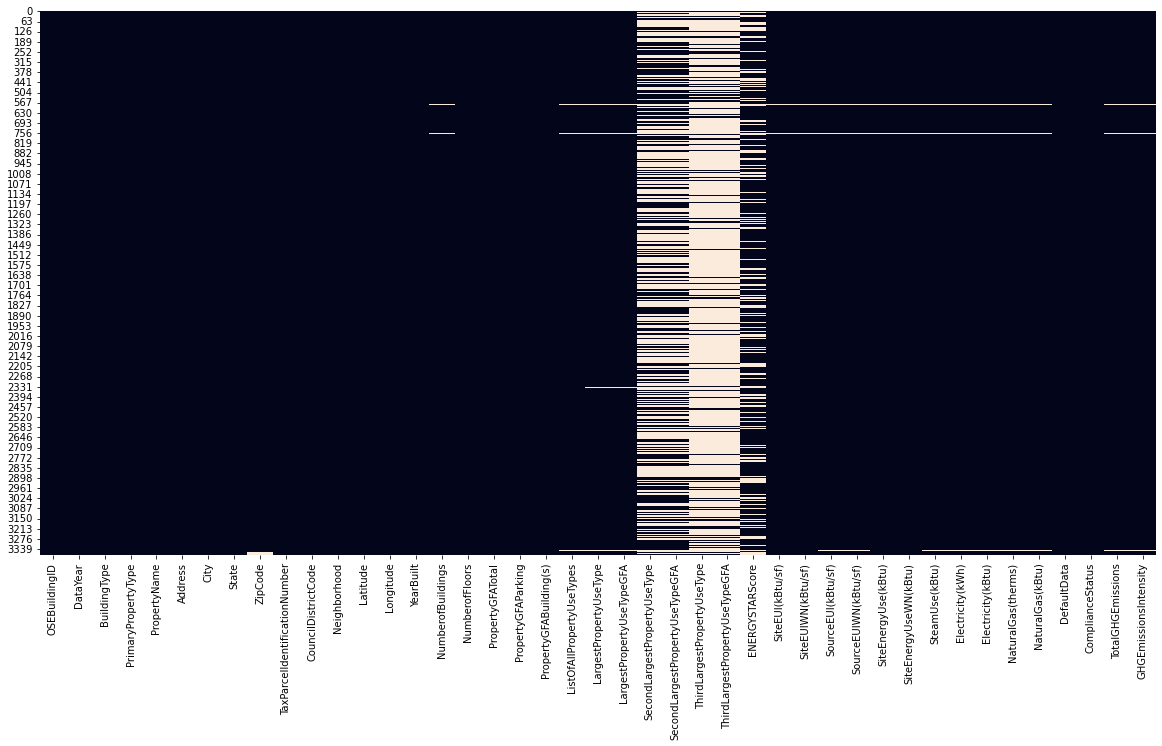

In [24]:
remove_column_nul(df,0.9)

Notre problematique nous demande d'etudier l'emission de co2 des battiments non-residentiels on se centrera alors sur ce type des données. 

Ci-bas, on observe la repartition des nombres des battiments par rapport au type des battiments, on remarque que nosu avons 3 caregorier qui contienes des information sur des battiments residentiel, dans la suite on tiendra pas compte de ses lignes ils seront supprimés. 

## Traitement des variables Quantitatives

C:\Users\cardn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='BuildingType', ylabel='NumberofBuildings'>

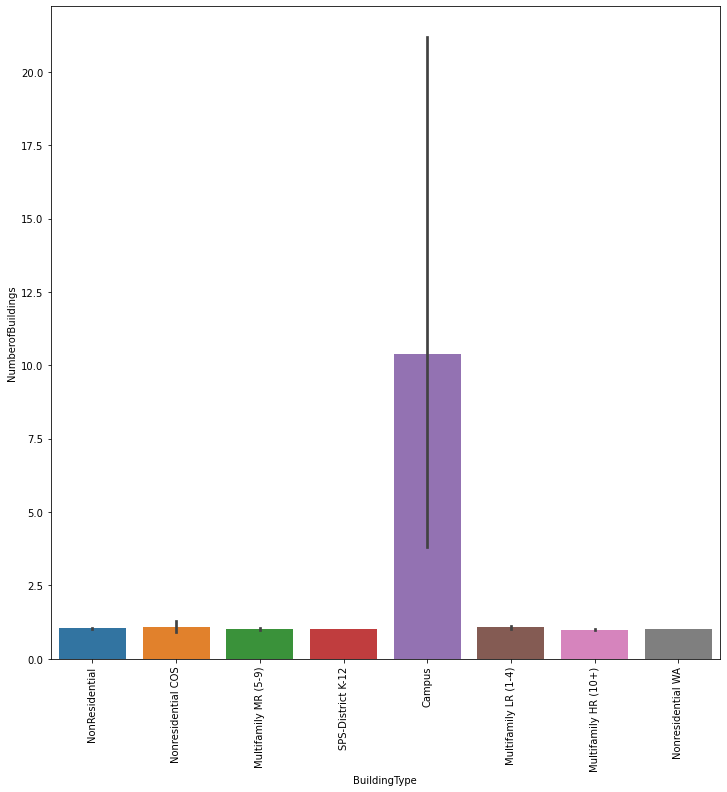

In [25]:
plt.figure(figsize=(12, 12))
plt.xticks(rotation=90)
sns.barplot(df['BuildingType'],
                       df['NumberofBuildings']) 

In [26]:
df=df.loc[df['BuildingType'].isin(['NonResidential','Nonresidential COS','Nonresidential WA','Campus','SPS-District K-12'])]

Dans ce qui suit, on regardera plus en profondeur les variables de type quantitative, pour cela qu'on commencera a observer les labels uniques qu'ils contient.

In [27]:
unique_object(df)

BuildingType-------------------------------------- ['NonResidential' 'Nonresidential COS' 'SPS-District K-12' 'Campus'
 'Nonresidential WA']
PrimaryPropertyType------------------------------- ['Hotel' 'Other' 'Mixed Use Property' 'K-12 School' 'University'
 'Small- and Mid-Sized Office' 'Self-Storage Facility' 'Warehouse'
 'Large Office' 'Senior Care Community' 'Medical Office' 'Retail Store'
 'Hospital' 'Residence Hall' 'Distribution Center' 'Worship Facility'
 'Supermarket / Grocery Store' 'Laboratory' 'Refrigerated Warehouse'
 'Restaurant' 'Low-Rise Multifamily' 'Office']
PropertyName-------------------------------------- ['Mayflower park hotel' 'Paramount Hotel' '5673-The Westin Seattle' ...
 'Queen Anne Pool' 'South Park Community Center'
 'Van Asselt Community Center']
Address------------------------------------------- ['405 Olive way' '724 Pine street' '1900 5th Avenue' ... '1920 1st Ave W'
 '8319 8th Ave S' '2820 S Myrtle St']
City---------------------------------------------- 

Dans la variable 'Neighborhood', on observe des noms des zones qui sont identiques, mais a different notation ou a different type d'ecriture on corrigera c'est erreur avant de continuer

In [28]:
df.loc[:,'Neighborhood'] = df.loc[:,'Neighborhood'].str.capitalize()

In [29]:
df.loc[:,'Neighborhood'].replace('Delridge neighborhoods','Delridge', inplace=True)

In [30]:
df.groupby(['PrimaryPropertyType','BuildingType']).size().head(50)

PrimaryPropertyType          BuildingType      
Distribution Center          NonResidential         51
                             Nonresidential COS      2
Hospital                     NonResidential         10
Hotel                        NonResidential         76
K-12 School                  Campus                  4
                             NonResidential         39
                             SPS-District K-12      96
Laboratory                   NonResidential         10
Large Office                 Campus                  1
                             NonResidential        168
                             Nonresidential COS      4
Low-Rise Multifamily         Campus                  1
                             NonResidential          2
Medical Office               NonResidential         38
                             Nonresidential COS      1
Mixed Use Property           Campus                  4
                             NonResidential        102
                 

In [31]:
df['LargestPropertyUseType']=df['LargestPropertyUseType'].fillna("Unknown")

C:\Users\cardn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='LargestPropertyUseType', ylabel='NumberofBuildings'>

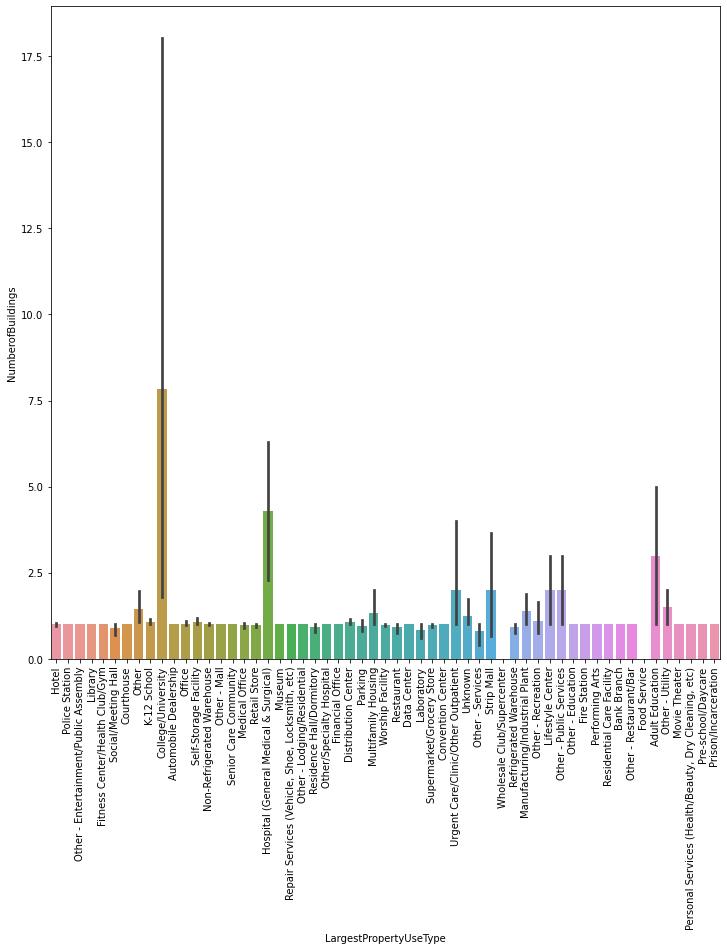

In [32]:
plt.figure(figsize=(12, 12))
plt.xticks(rotation=90)
sns.barplot(df['LargestPropertyUseType'],
                       df['NumberofBuildings']) 

<div align="justify">Comme on a pu observer ci-dessus, les types des battiments qu'on a recuperer sont du type non residential, on peut donc considerer que notre dataframe est bien regler pour les information des emissions de co2 pour les battiments non-Residential. Pour la suite la variable BuildingType sera effacé, apres avoir vu la repartition des données par rapports aux variables qualitatives, car les informations qu'elle pourrai nous apportait ne seront plus interessant.</div>
<p></p>
<div align="justify">De même, on a pu observer que City et State on seulement une seule valeur, ce qui est normal car nous etudions les emissions de co2 de la ville de seatle, donc la ville et l'etat vont etre toujours les mêmes, ces valeurs ne doivent pas changer, si on aurais eu, une valeur differente, on aurai donc du se poser comme question si c'etait une erreur de typage ou une valeur aberrant qu'aurai du etre traité avant d'etre effacé.</div>
<p></p>
<div align="justify">Les variables PropertyName, Address, TaxParcelIdentificationNumber, ListOfAllPropertyUseTypes, TaxParcelIdentificationNumber, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseTypeGFA, ComplianceStatus  ont beaucoup d'informations differents mais qui ne sont pas interessant a traiter car elles n'apportaient plus d'information a notre problematique, ce pour cela qu'on les effacera.</div>
<p></p>
<div align="justify">Les variables PrimaryPropertyType, Neighborhood et LargestPropertyUseType sont les variables qui nous apportent plus d'informations, dans la suite on conservera ces variables.</div> 

In [33]:
delete_object =['City','State','PropertyName','Address','TaxParcelIdentificationNumber',
               'TaxParcelIdentificationNumber',
               'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ComplianceStatus']
remove_column(df,delete_object)

## Traitement des variables qualitatives

Pour commencer, on effacera les données qui ne sont pas pertinent dans notre traitement 

In [34]:
remove_column(df,['OSEBuildingID','DataYear','DefaultData','CouncilDistrictCode','ZipCode'])

Puis on regardera, la correlation entre les variables afin de supprimés les variables qui sont fortement corrélés

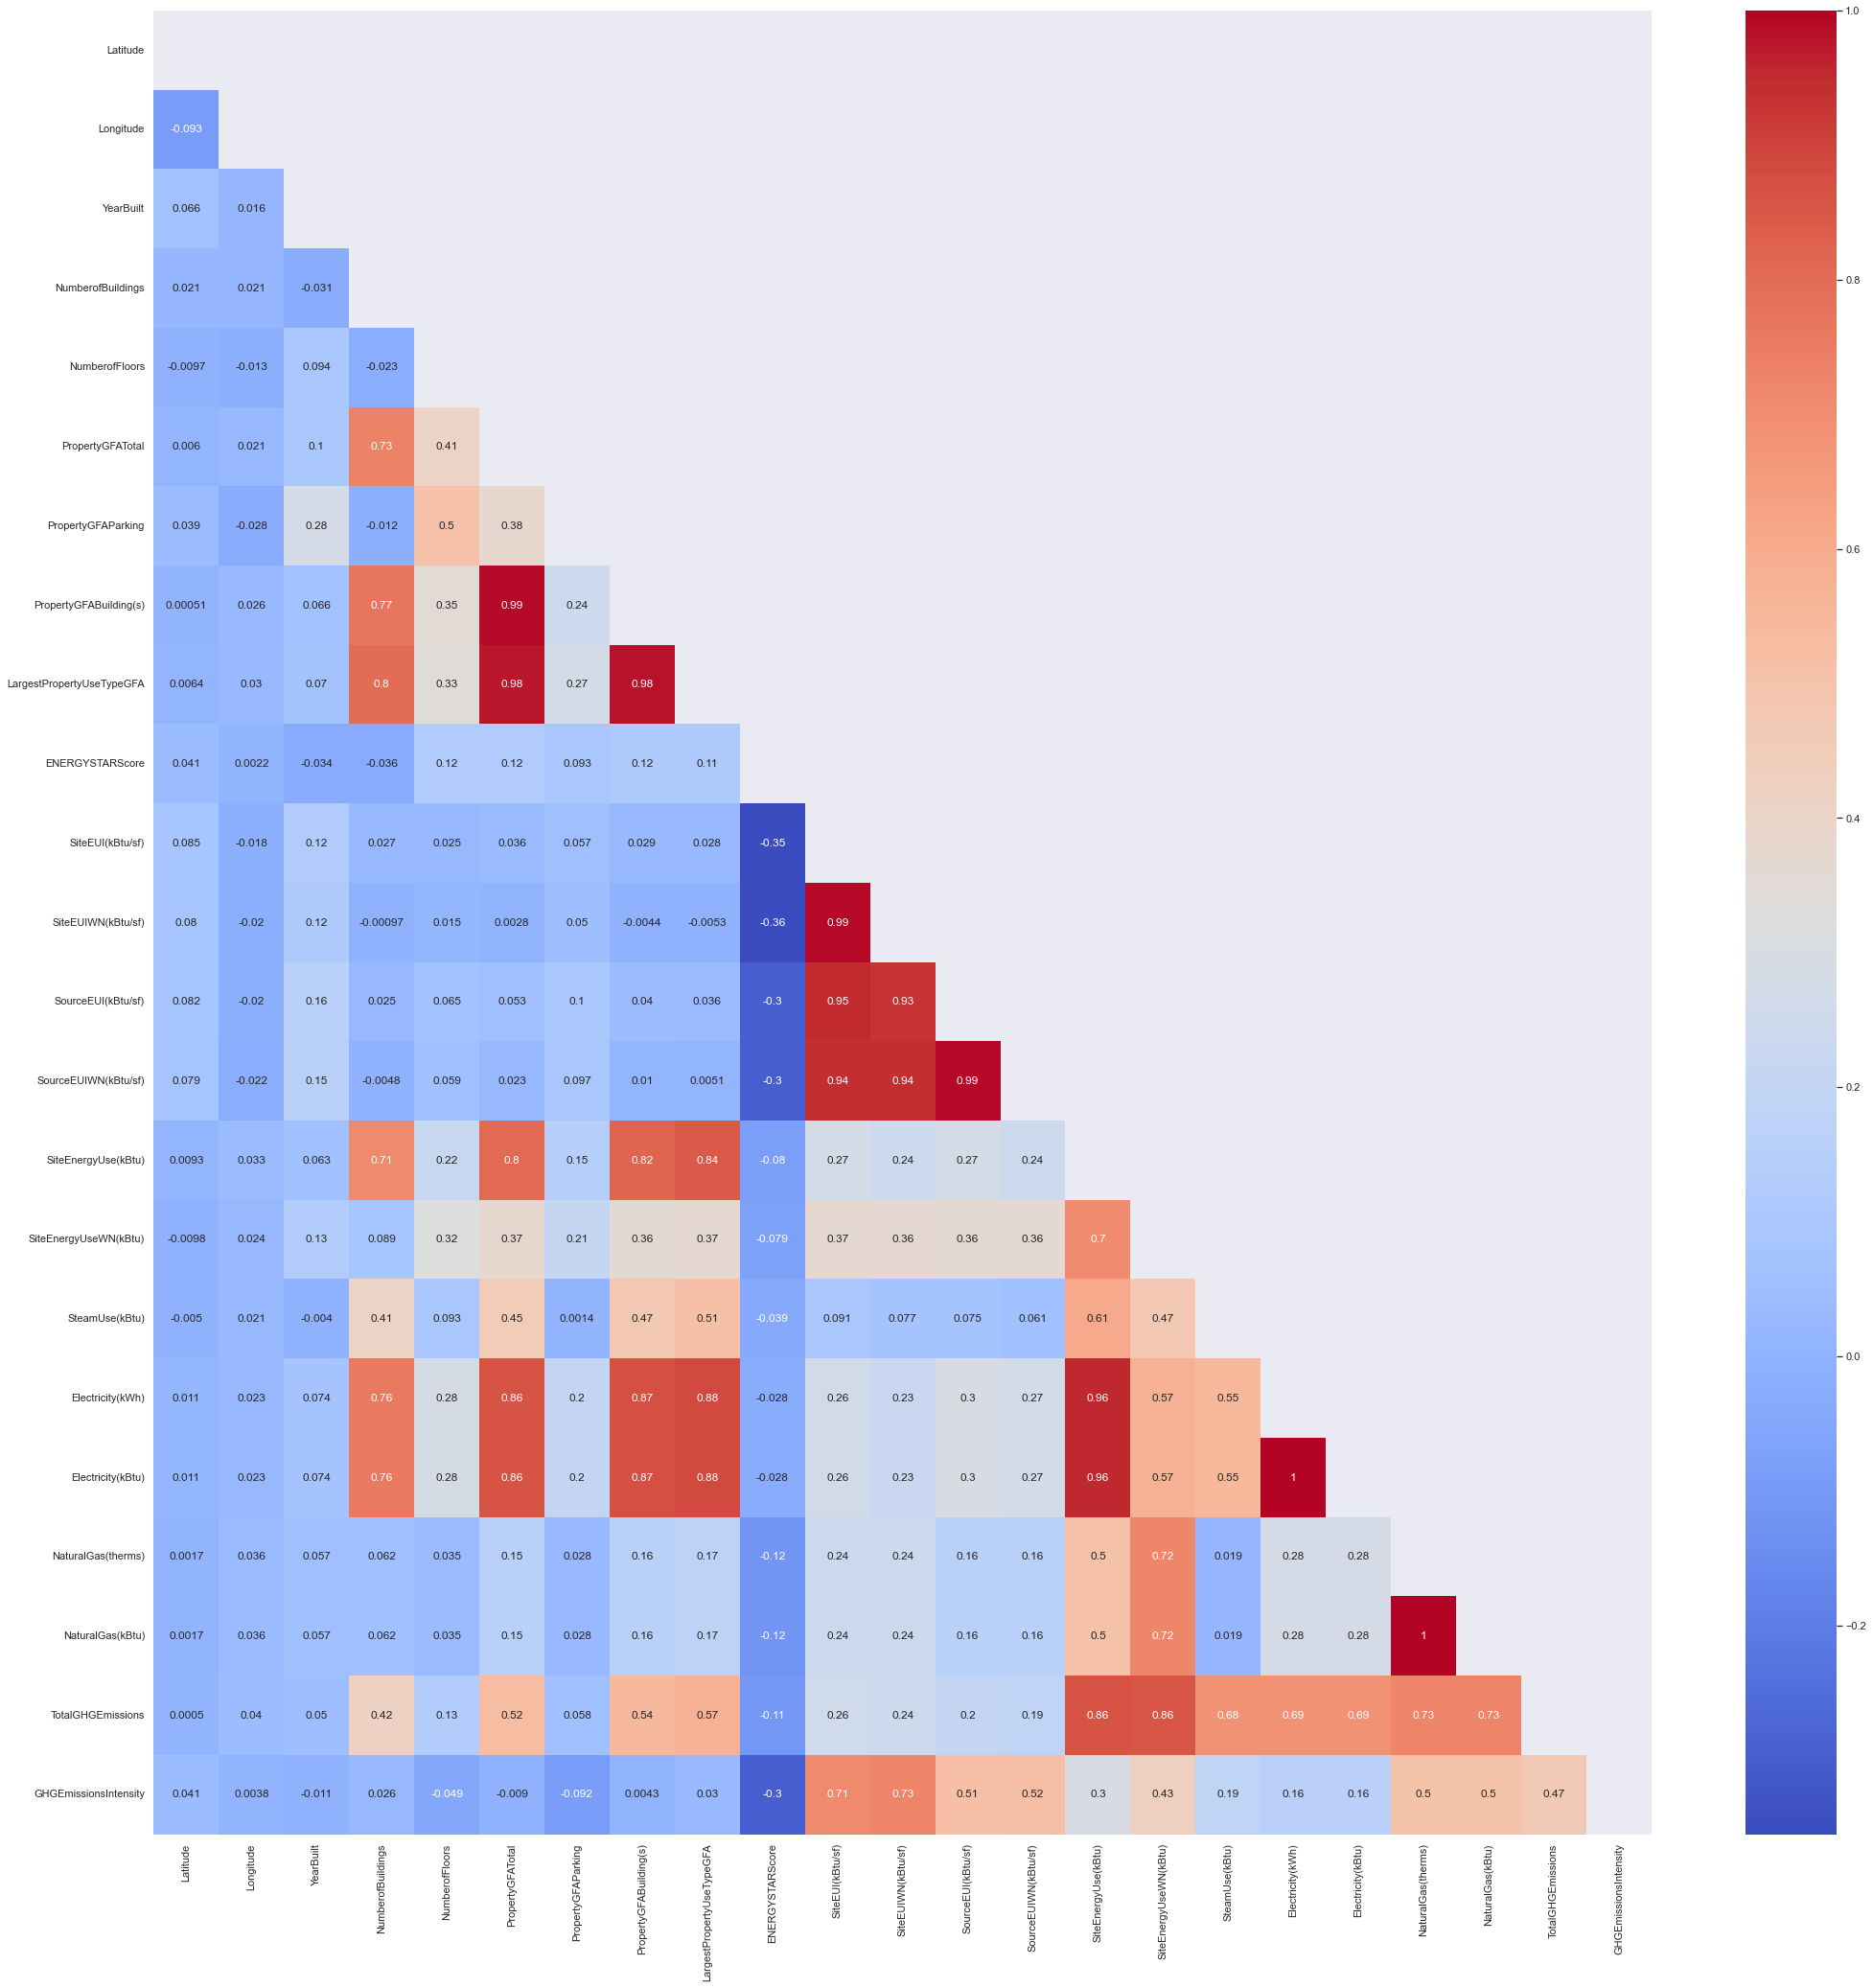

In [35]:
sns.set(rc={'figure.figsize':(35,35)})

df_corr = df.corr()
mask = np.triu(np.ones_like(df_corr, dtype=bool))
ax = sns.heatmap(df_corr, xticklabels = df_corr.columns , yticklabels = df_corr.columns,
                 mask=mask, cmap = 'coolwarm', annot=True)

On observe quelques variables qui ont les mêmes nom et une forte corrélation, mais ils ont exprimés dans des unités des mesures differentes, on peut donc se demander s'il est interessant de conserver ces valeurs.

Dans la suite on observera ces variables, afin de determiner s'il est interessant de conserver les 2 valeurs:

    - SiteEUI(kBtu/sf)/SiteEUIWN(kBtu/sf)
    - SourceEUI(kBtu/sf)/SourceEUIWN(kBtu/sf)
    - SiteEnergyUse(kBtu)/SiteEnergyUseWN(kBtu)
    - Electricity(kWh)/Electricity(kBtu)
    - NaturalGas(therms)/NaturalGas(kBtu)
    

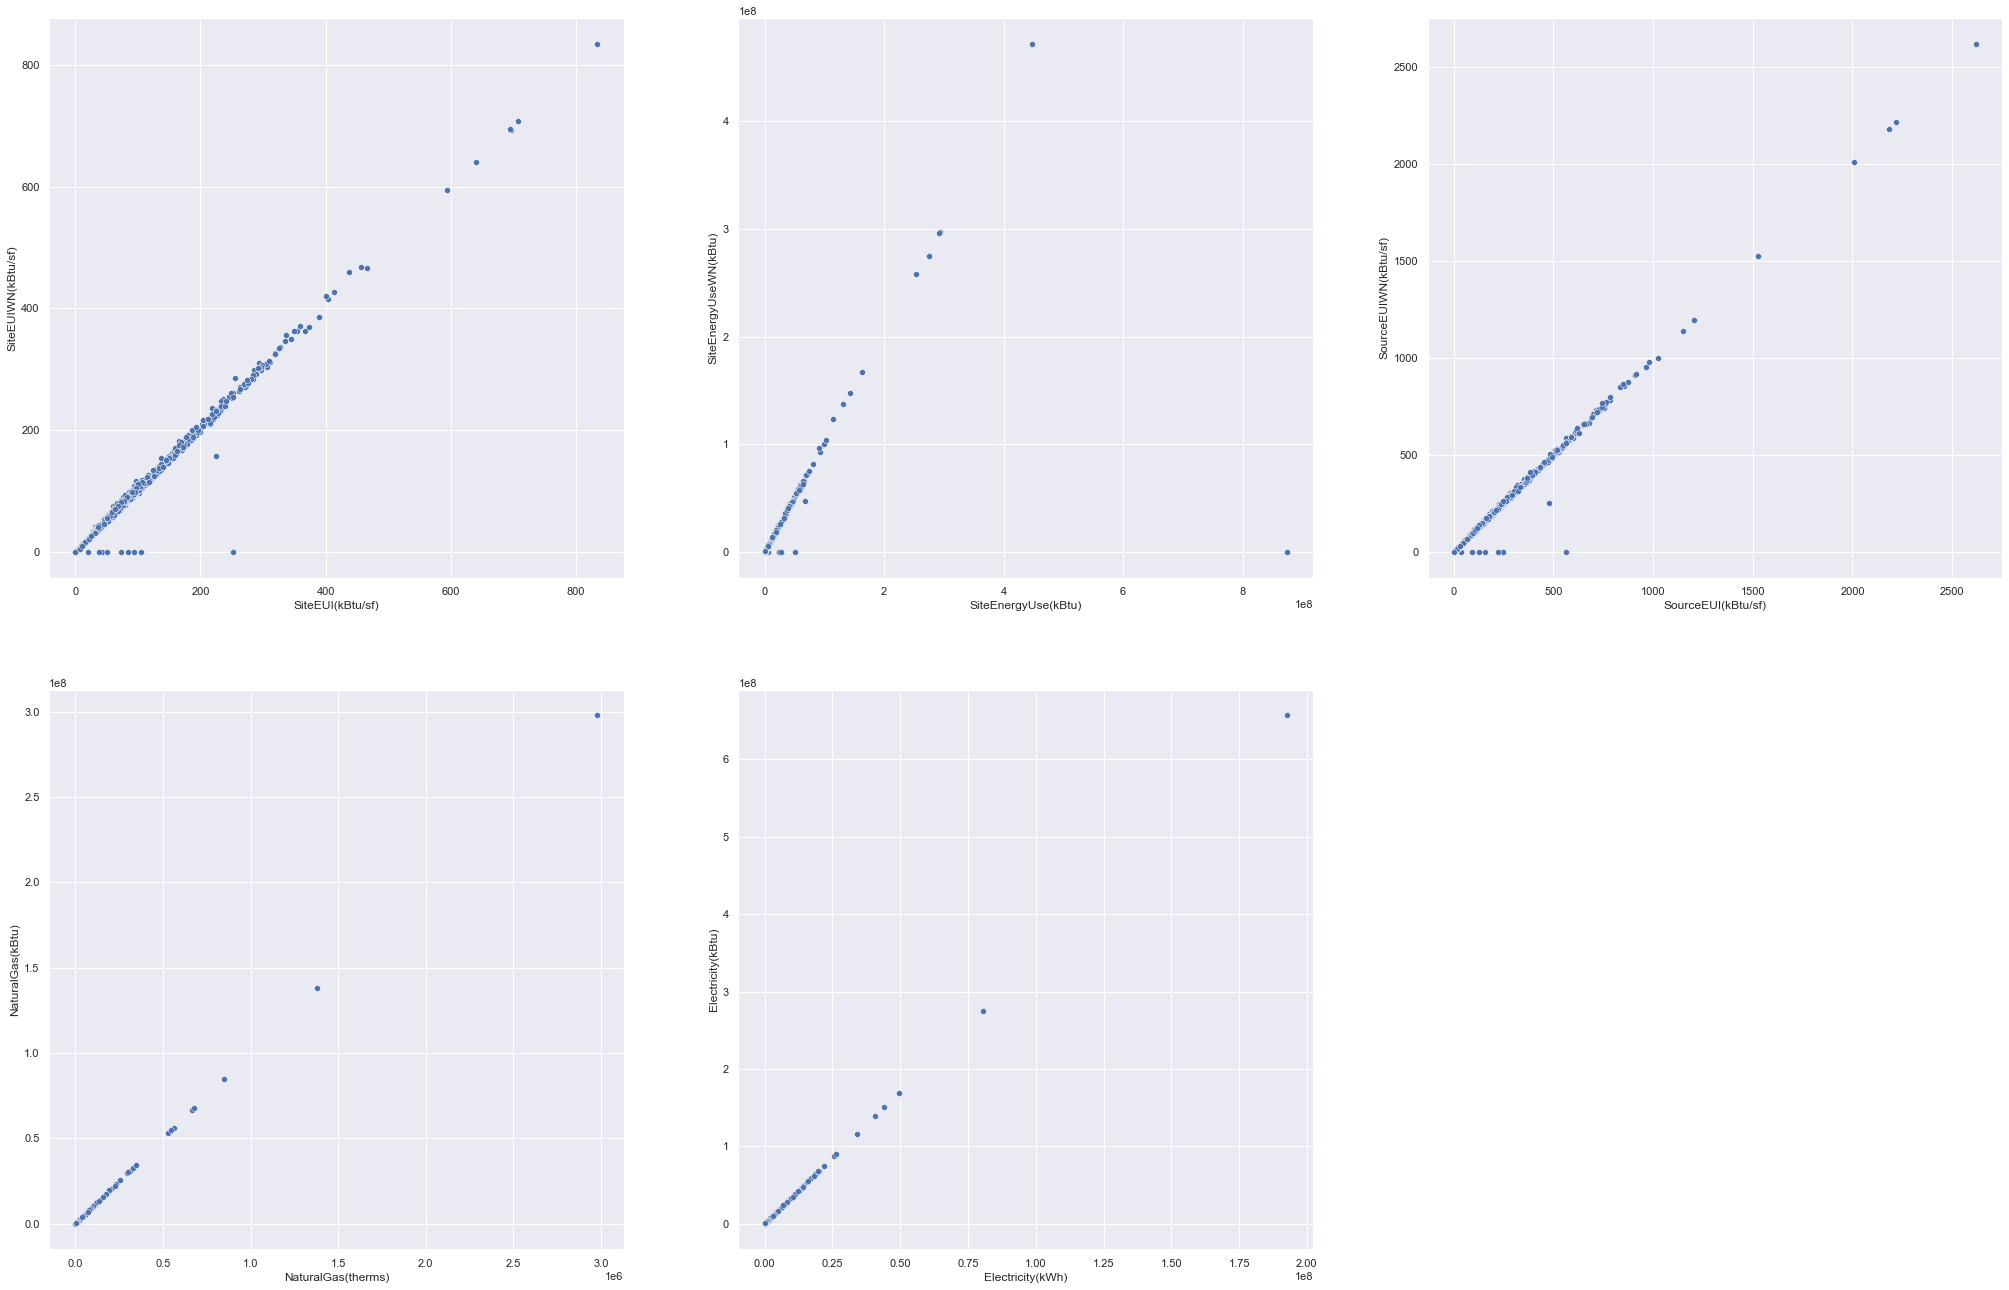

In [36]:
fig = plt.figure()
sns.set_theme()
axes = fig.add_subplot(3,3,1)
scatter(df,'SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)')
axes = fig.add_subplot(3,3,2)
scatter(df,'SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)')
axes = fig.add_subplot(3,3,3)
scatter(df,'SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)')
axes = fig.add_subplot(3,3,4)
scatter(df,'NaturalGas(therms)','NaturalGas(kBtu)')
axes = fig.add_subplot(3,3,5)
scatter(df,'Electricity(kWh)','Electricity(kBtu)')

<div align="justify">On peut observer ci-dessus, que les variables naturalgas et electricity ont une evolution linaire, on peut donc considerer que les variables qui representent le gas et l'electricite apportent les mêmes informations mais avec des differents unités, on peut donc conserver l'une de ces variables, dans notre cas on choisira la variable a l'unité kBtu car il simplifié le calcul entre colonnes.</div>
<p></p>
<div align="justify">On observe aussi que les variables siteEUI, siteEnergy et SourceEUI ont une evolution quasi-lineaire, on peut donc se poser comme question si ces variables apportent vraiment des informations en plus; apres observation les variables avec le suffixe WN, represente des mesures normalisées avec les conditions climatiques, on ne le prendra pas en compte dans notre analyse.</div>

In [37]:
remove_column(df,['NaturalGas(therms)','Electricity(kWh)','SourceEUIWN(kBtu/sf)','SiteEnergyUseWN(kBtu)','SiteEUIWN(kBtu/sf)'])

De même, il y a des variables qui nous apportentdes information redondant, ou des informations quis sont faciles a trouver a partir des autres variables, comme par exemple la consomation d'energie par suface des etages, de même que l'intensité d'emission de gaz, ce pour cela que ces variables seront supprimés.

In [38]:
remove_column(df,['SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','GHGEmissionsIntensity'])

De même, on peut exprimer les variables Latitude et Longitude dans une seule variable en appliquant, un changement de repere par rapport au centre ville.

In [39]:
rayon_terre=6371
# Mairie de Seattle 
x=np.ones(1668)*np.radians(47.6038904)
y=np.ones(1668)*np.radians(-122.3300986)
x1=df['Latitude']
y1=df['Longitude']
x1=np.radians(x1)
y1=np.radians(y1)
sin=np.sin(x)*np.sin(x1)
longitude_delta=y1-y
rayon_terre=6371
cos=np.cos(x)*np.cos(x1)*np.cos(longitude_delta)
distance_angulaire=np.arccos(sin+cos)
df['distance']=distance_angulaire*rayon_terre

remove_column(df,['Latitude','Longitude'])

Avant de continuer, il est prudent de se demander si a la suite des traitements realisés, on a generé ou modifié la proportion des valeurs manquantes, ce pour cela qu'avant de continuer au traitement on regardera encore une fois les taux des valeurs manquantes

In [40]:
df.isnull().mean().sort_values(ascending=False)

ThirdLargestPropertyUseType     0.788369
SecondLargestPropertyUseType    0.487410
ENERGYSTARScore                 0.344125
LargestPropertyUseTypeGFA       0.003597
TotalGHGEmissions               0.001199
NaturalGas(kBtu)                0.001199
NumberofBuildings               0.001199
Electricity(kBtu)               0.001199
SteamUse(kBtu)                  0.001199
SiteEnergyUse(kBtu)             0.001199
ListOfAllPropertyUseTypes       0.001199
BuildingType                    0.000000
LargestPropertyUseType          0.000000
PrimaryPropertyType             0.000000
PropertyGFABuilding(s)          0.000000
PropertyGFAParking              0.000000
PropertyGFATotal                0.000000
NumberofFloors                  0.000000
YearBuilt                       0.000000
Neighborhood                    0.000000
distance                        0.000000
dtype: float64

On observe, que nous avons 3 variables qui contient la pluspart des valeur manquante, ayant 2 variables qui peuvent etre representé ou retrouver avec des autres varibales, ce pas la peine des les conservers, on conservera alors que les variables qui ont un taux des valeus manquantes superieur a 40%

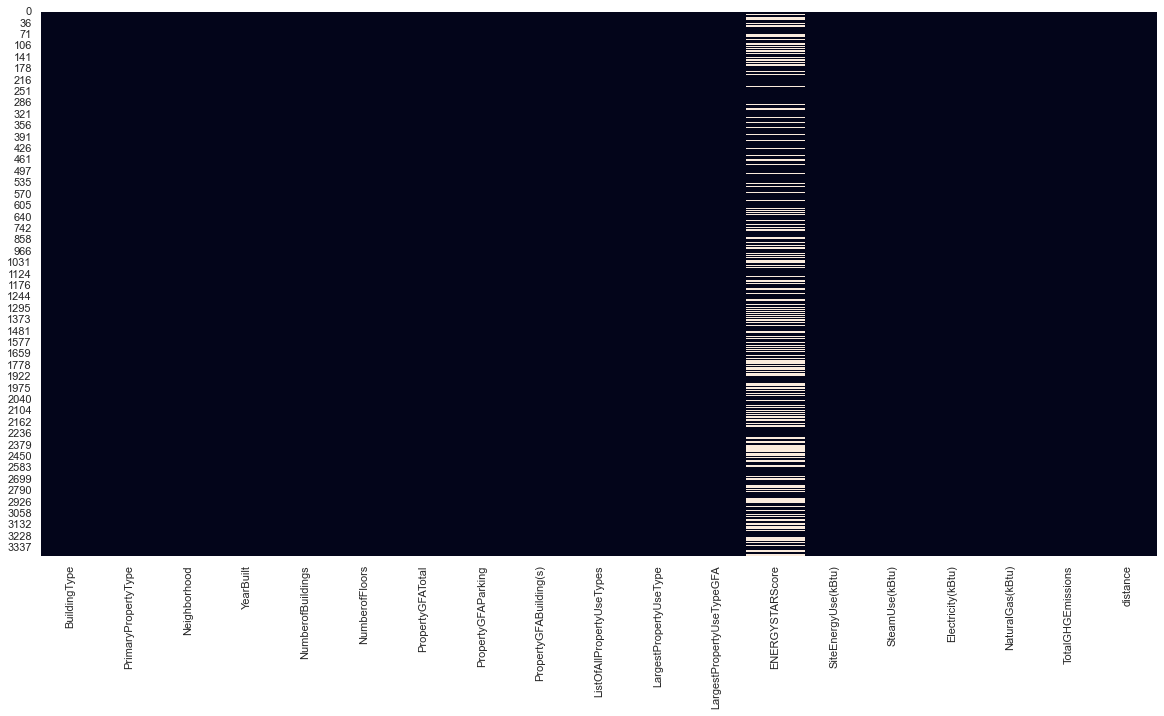

In [41]:
remove_column_nul(df,0.4)

<div align="justify">Avant de continuer avec l'analyse exploratoire des données, on peut creer une nouvelle variable avec les données d'acquisiton et la construction du battiment afin de recuperer l'ages du batiment</div>

In [42]:
df['BuildingAge']=2022-df['YearBuilt']

# Analyse Exploratoire

Dans la suite, on s'interessera plus en profondeur dans les données quantitatives

Pour commencer, on observera l'evolution des variables a predire

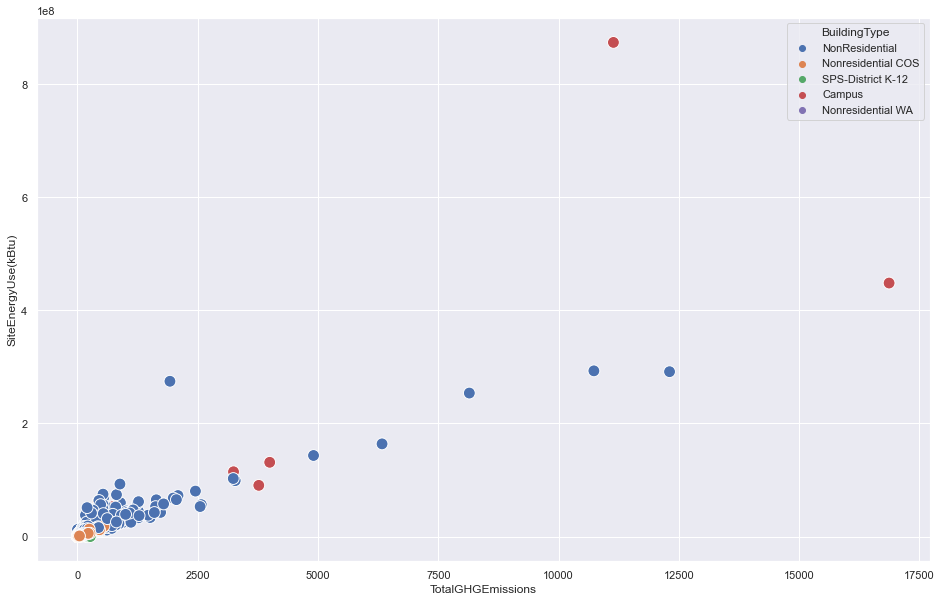

In [43]:
plt.figure(figsize=(16, 10))
sns.scatterplot(y='SiteEnergyUse(kBtu)',
                x='TotalGHGEmissions',
                data=df,
                s=140,
                hue='BuildingType')
plt.show()

On observe 2 outliers, chacun appartenant a un campus, dans la suite on realisera un centrage

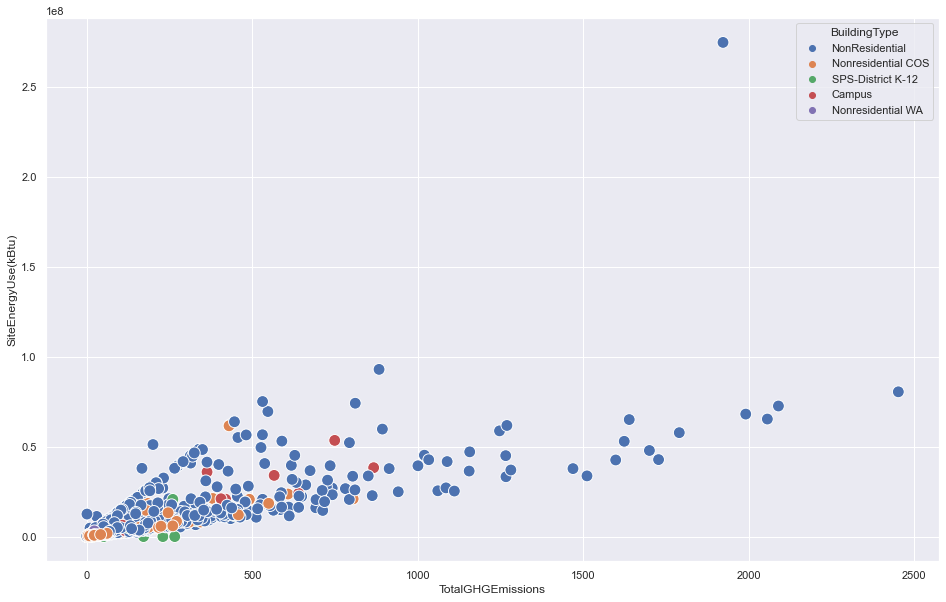

In [44]:
plt.figure(figsize=(16, 10))
sns.scatterplot(y='SiteEnergyUse(kBtu)',
                x='TotalGHGEmissions',
                data=df[df['TotalGHGEmissions'] < 2500],
                s=140,
                hue='BuildingType')
plt.show()

In [45]:
df[df['SiteEnergyUse(kBtu)'] > 4*10**8]

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,distance,BuildingAge
35,Campus,Mixed Use Property,Greater duwamish,1992,1.0,3,494835,0,494835,"Energy/Power Station, Laboratory, Manufacturin...",Office,757027.0,8.0,448385312.0,0.0,150476283.0,297909000.0,16870.98,7.722644,30
3274,Campus,University,Northeast,1900,111.0,0,9320156,0,9320156,College/University,College/University,9320156.0,NaN,873923712.0,84985240.0,657074389.0,0.0,11140.56,6.026633,122


In [46]:
df[df['TotalGHGEmissions'] > 15*10**3]


,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,distance,BuildingAge
35,Campus,Mixed Use Property,Greater duwamish,1992,1.0,3,494835,0,494835,"Energy/Power Station, Laboratory, Manufacturin...",Office,757027.0,8.0,448385312.0,0.0,150476283.0,297909000.0,16870.98,7.722644,30


In [47]:
df=df[df['SiteEnergyUse(kBtu)'] < 4*10**8]
df=df[df['TotalGHGEmissions'] < 15*10**3]

C:\Users\cardn\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\cardn\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


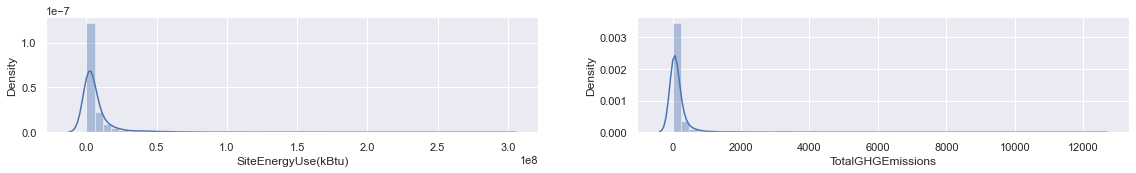

In [48]:
distplots(df,['SiteEnergyUse(kBtu)','TotalGHGEmissions'])

On observe que la distribution des données est centré sur zero, on peut donc se demander si ces variables suivent une distribution Gaussiennes, ce pour cela que a la fin de l'analyse exploratoire on realisera les test statistiques.

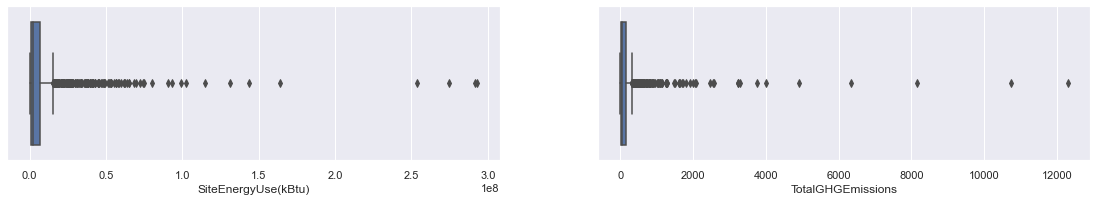

In [49]:
boxplots(df,['SiteEnergyUse(kBtu)','TotalGHGEmissions'])

Dans le graphe du quartile, on observe que nous avons des variables qui sont tres proches du max, apres observation, on remarque qu'il sont des lieux hospitalier, donc lo consommation est dans la rang de l'acceptable.

In [50]:
df[df['SiteEnergyUse(kBtu)'] > 2.5*10**8]

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,distance,BuildingAge
124,NonResidential,Hospital,Northeast,1953,6.0,10,879000,0,879000,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),879000.0,10.0,253832464.0,0.0,115641210.0,138191238.0,8145.52,7.448516,69
170,NonResidential,Hospital,East,2000,9.0,8,1158691,0,1158691,"Hospital (General Medical & Surgical), Parking",Hospital (General Medical & Surgical),1350182.0,29.0,293090784.0,122575032.0,168683602.0,1832129.0,10734.57,0.474606,22
558,NonResidential,Other,Downtown,1981,1.0,33,429405,0,429405,"Data Center, Office",Data Center,218997.0,98.0,274682208.0,0.0,274532495.0,149672.0,1921.82,1.333123,41
618,NonResidential,Hospital,East,1994,7.0,14,1765970,0,1765970,"Hospital (General Medical & Surgical), Parking",Hospital (General Medical & Surgical),1639334.0,54.0,291614432.0,134943456.0,139354828.0,17316120.0,12307.16,0.805971,28


In [51]:
df[df['TotalGHGEmissions'] > 8*10**3]

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,distance,BuildingAge
124,NonResidential,Hospital,Northeast,1953,6.0,10,879000,0,879000,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),879000.0,10.0,253832464.0,0.0,115641210.0,138191238.0,8145.52,7.448516,69
170,NonResidential,Hospital,East,2000,9.0,8,1158691,0,1158691,"Hospital (General Medical & Surgical), Parking",Hospital (General Medical & Surgical),1350182.0,29.0,293090784.0,122575032.0,168683602.0,1832129.0,10734.57,0.474606,22
618,NonResidential,Hospital,East,1994,7.0,14,1765970,0,1765970,"Hospital (General Medical & Surgical), Parking",Hospital (General Medical & Surgical),1639334.0,54.0,291614432.0,134943456.0,139354828.0,17316120.0,12307.16,0.805971,28


Dans ce qui suit, on regardera la consomation d'energie ainsi que le total des emissions de co2 par rapport aux categories des battiments

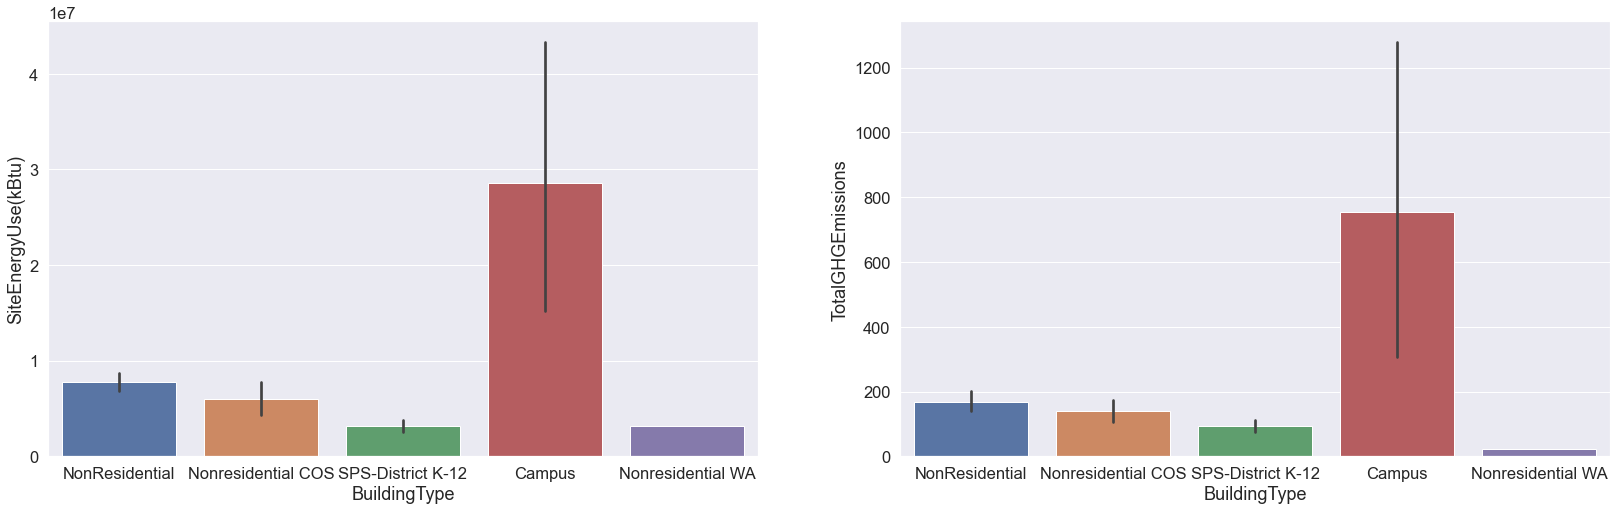

In [52]:
sns.set_theme(style="white", palette=None)
sns.set(rc = {'figure.figsize':(28,8)}, font_scale=1.5)
fig, axes = plt.subplots(1, 2)

sns.barplot(ax=axes[0], data=df, y='SiteEnergyUse(kBtu)', x='BuildingType')
sns.barplot(ax=axes[1], data=df, y='TotalGHGEmissions', x='BuildingType')

plt.show()

On observe que les campus generent le plus des emissions de co2 et aussi qu'ils consomment beaucoup plus d'energie que les autres categories des battiments.

Dans ce qui suit, on observera la distrubition des battiment par tranche d'age et ainsi que para année de construction

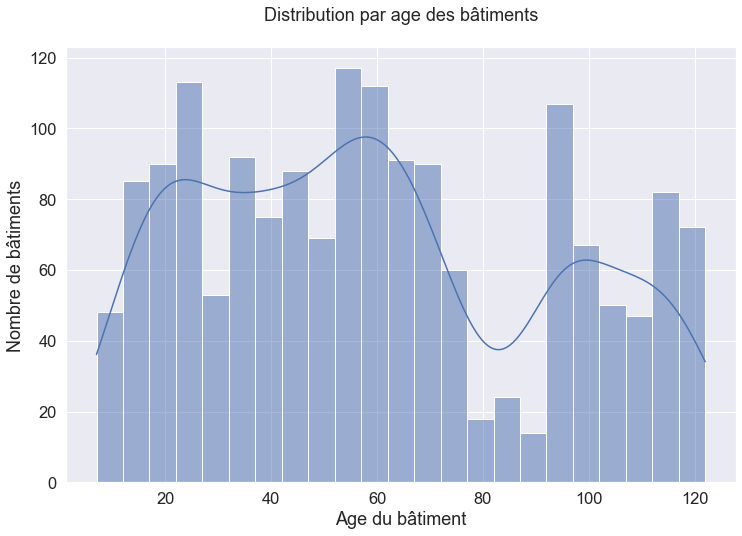

In [53]:
fig = plt.figure(figsize=(12,8))
ax = sns.histplot(data=df, x='BuildingAge', kde=True,bins=int((df.BuildingAge.max() - df.BuildingAge.min())/5))
ax.set_xlabel("Age du bâtiment")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution par age des bâtiments\n")
plt.show()

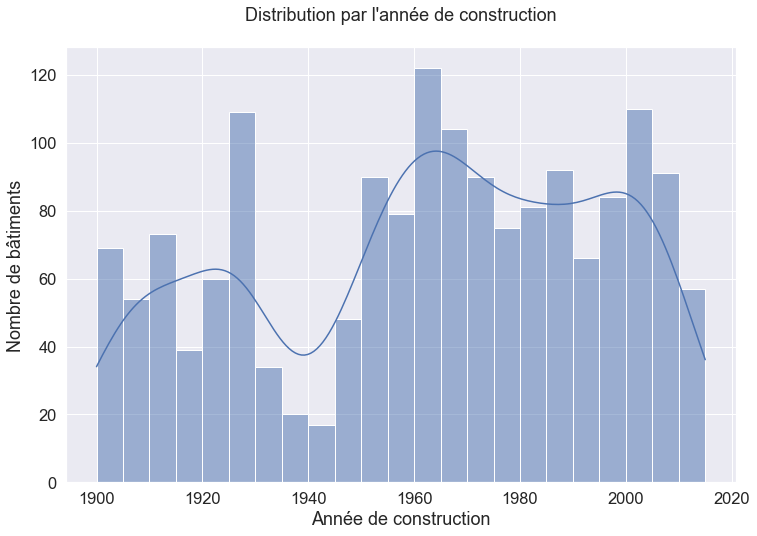

In [54]:
fig = plt.figure(figsize=(12,8))
ax = sns.histplot(data=df, x='YearBuilt',kde=True,bins=int((df.YearBuilt.max() - df.YearBuilt.min())/5))
ax.set_xlabel("Année de construction")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution par l'année de construction\n")
plt.show()

On observe, que la distribution des battiments par rapport a l'age n'est pas homegene ce qui est normal car on peut le traduire par des evenement passée dans l'année de construction, comme par exemple la periode avant et apres guerre, on observe une diminution important des construction de même pendant la periode de la mondialisation on observation une montée dans les nombres des construction ce qui est representé pour une plus fort densité des battiment a cette age, dans la suite on peut regarder la consomation et l'emission de co2 des battiments de chaque age.

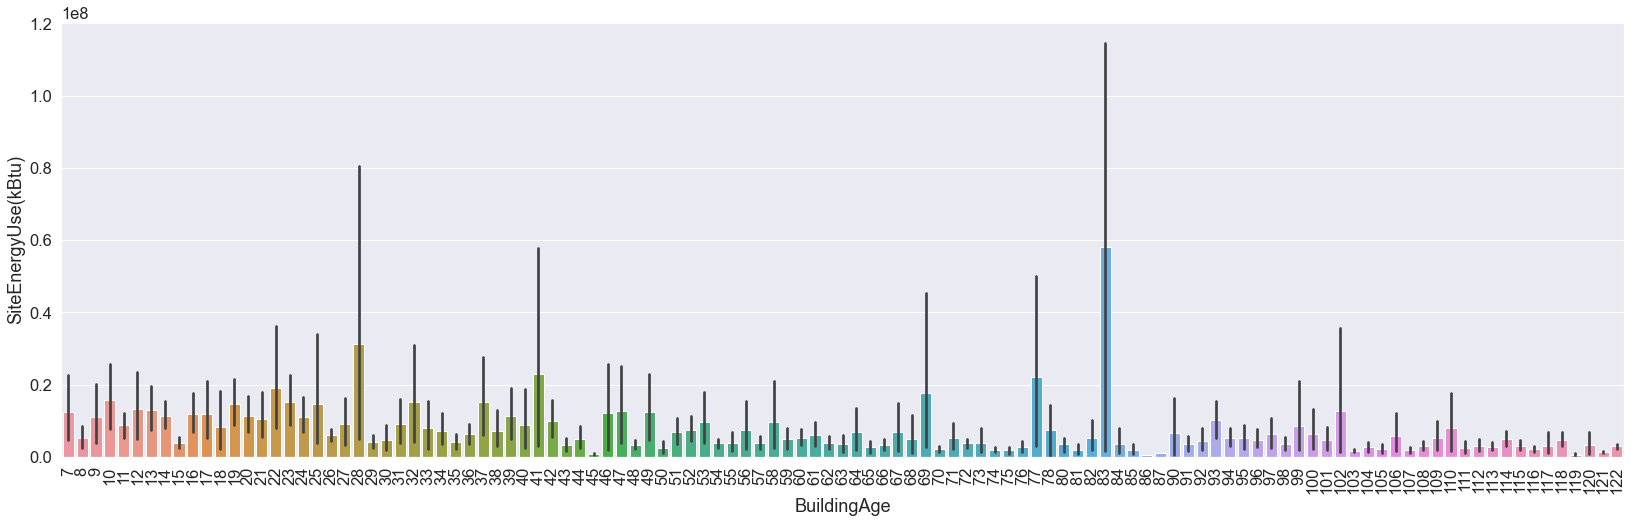

In [55]:
sns.barplot( data=df, y='SiteEnergyUse(kBtu)',x='BuildingAge')
plt.xticks(rotation=90)
plt.show()

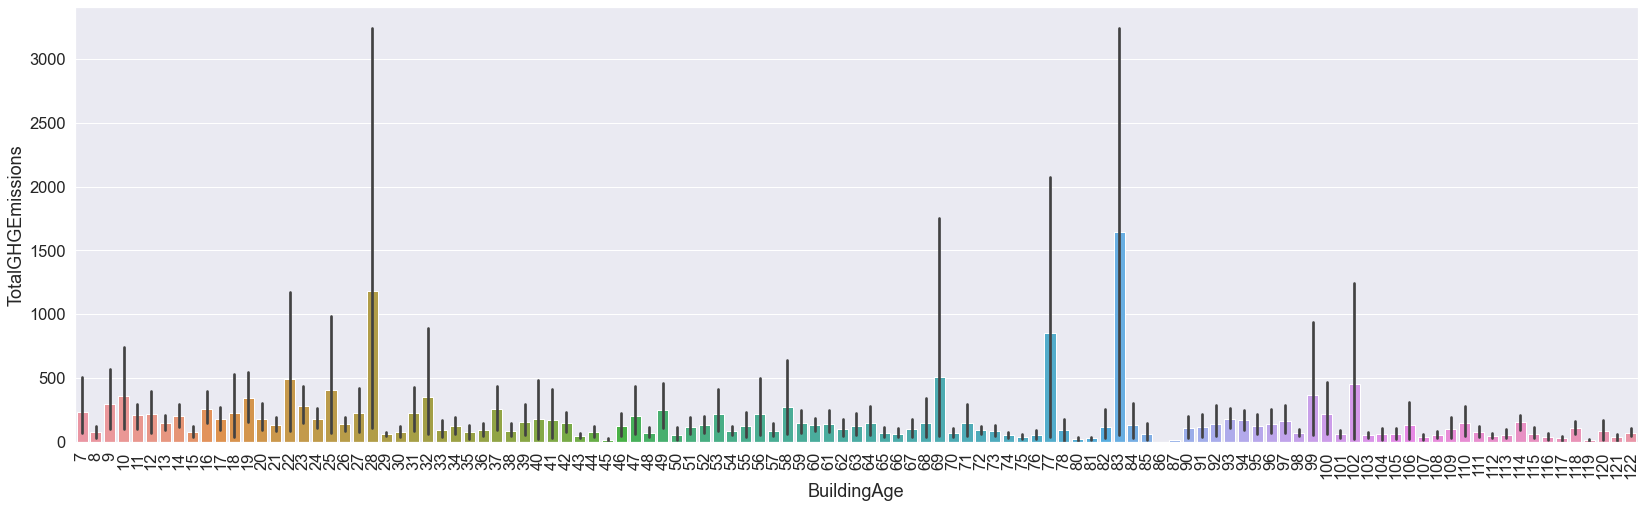

In [56]:
sns.barplot( data=df, y='TotalGHGEmissions',x='BuildingAge')
plt.xticks(rotation=90)
plt.show()

Des 2 graphes ci-dessus, on observe que les battiments des 83 ans et de 28 ans generent plus d'emission de co2, ainsi qu'il consomment plus d'energie

In [57]:
df['HistoricalPeriod']=pd.qcut(df['YearBuilt'], 
                                 q=[0,0.115,0.138,0.24,0.2759,0.289,0.455,0.75,0.87,1],
                                 labels=['Debut du siecle','Premiere guerre mondiale',
                                         'Années folles','Crise','Deuxieme guerre mondiale',
                                         'Guerre froide','Coexistence','mondialisation','actualité'])
remove_column(df,'YearBuilt')

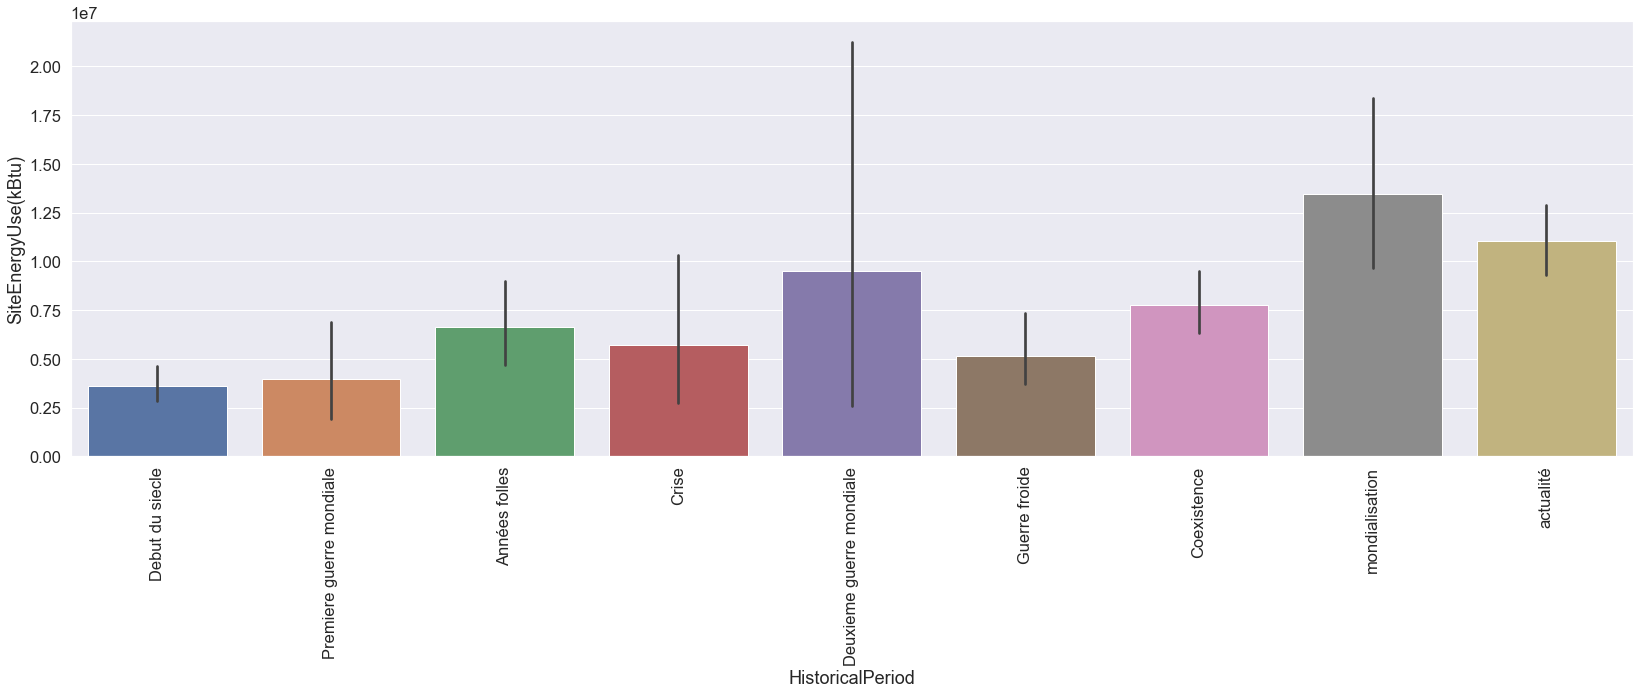

In [58]:
sns.barplot( data=df, y='SiteEnergyUse(kBtu)',x='HistoricalPeriod')
plt.xticks(rotation=90)
plt.show()

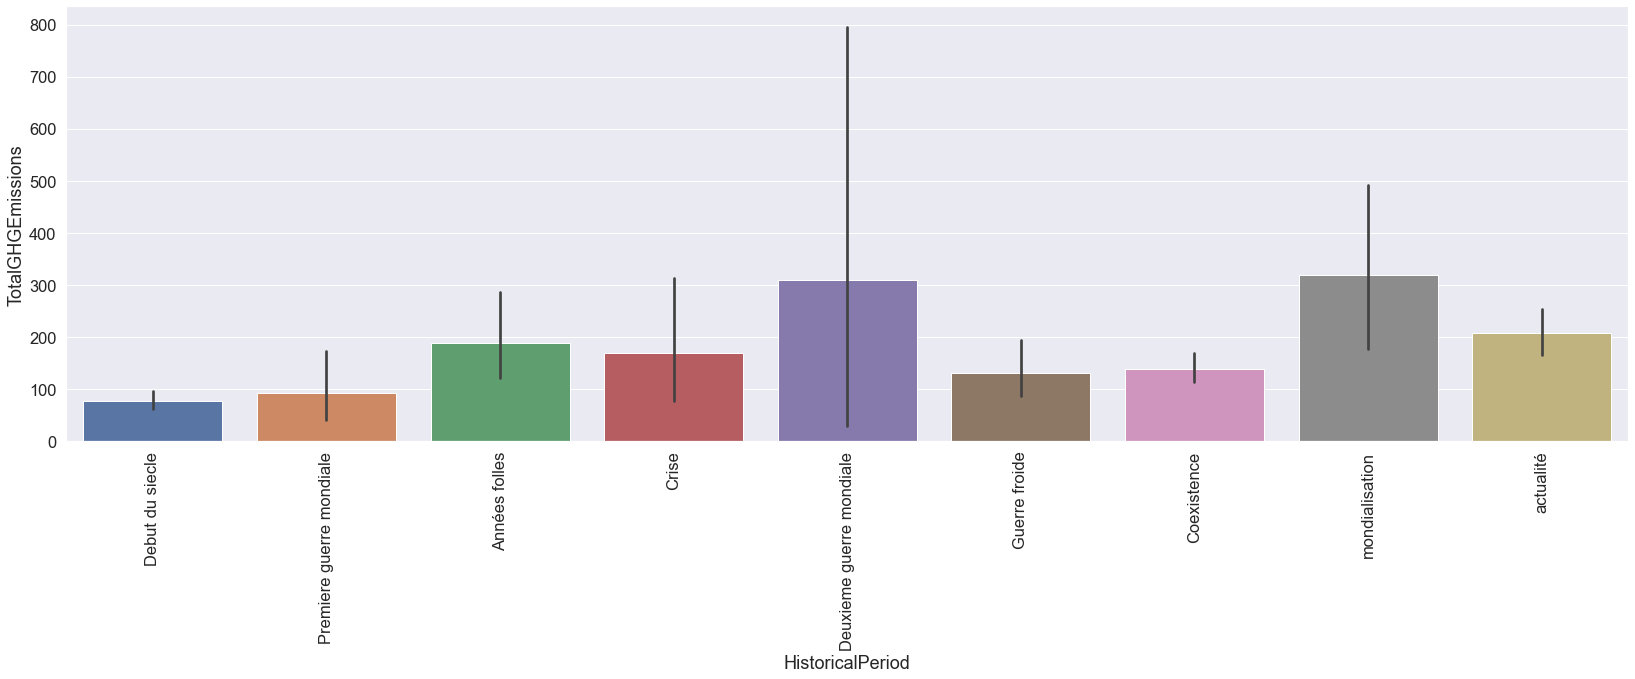

In [59]:
sns.barplot( data=df, y='TotalGHGEmissions',x='HistoricalPeriod')
plt.xticks(rotation=90)
plt.show()

Ci-dessus, on observe que les periodes dans lequels on consome le plus d'energie sont les periodes de la deuxieme guerre mondiale, la mondialisation et actualité. On observe aussi que l'emissions de co2 sont plus important dans les periodes de la deuxieme guerre mondiale et de la mondialisation.

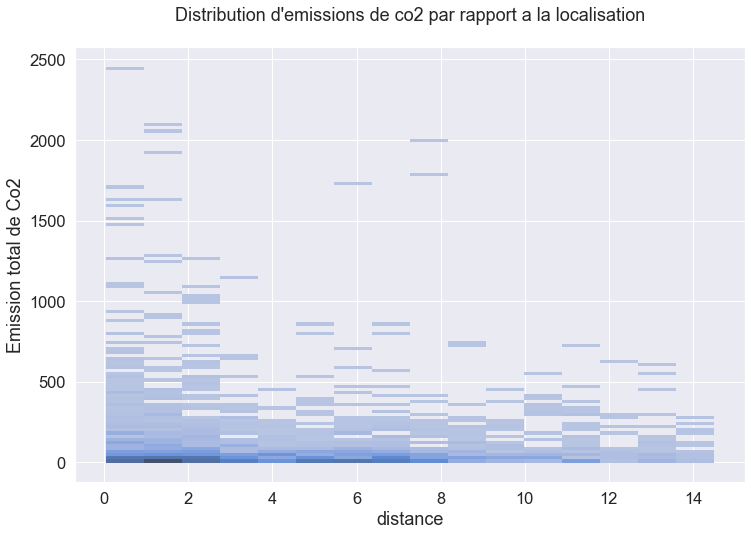

In [60]:
fig = plt.figure(figsize=(12,8))
ax = sns.histplot(data=df[(df['TotalGHGEmissions'] < 2500)],y='TotalGHGEmissions', x='distance')
ax.set_xlabel("distance")
ax.set_ylabel("Emission total de Co2")
plt.title(f"Distribution d'emissions de co2 par rapport a la localisation\n")
plt.show()

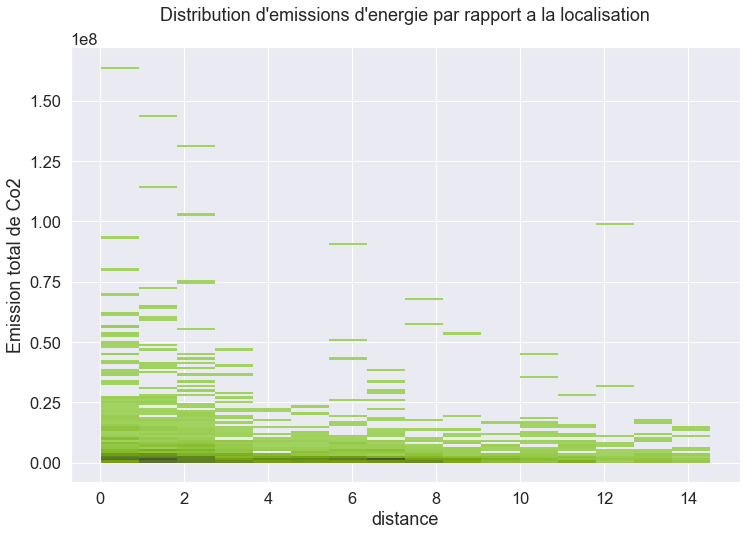

In [61]:
fig = plt.figure(figsize=(12,8))
ax = sns.histplot(data=df[(df['SiteEnergyUse(kBtu)'] < 2*10**8)],y='SiteEnergyUse(kBtu)', x='distance',  color="#6D9C0E")
ax.set_xlabel("distance")
ax.set_ylabel("Emission total de Co2")
plt.title(f"Distribution d'emissions d'energie par rapport a la localisation\n")
plt.show()

Par rapport aux distance, on observe une forte emission et consomation d'energie selon les Km de distance qu'on sera du centre ville, dans la suite on regardera les emission et la consomation par quartier.

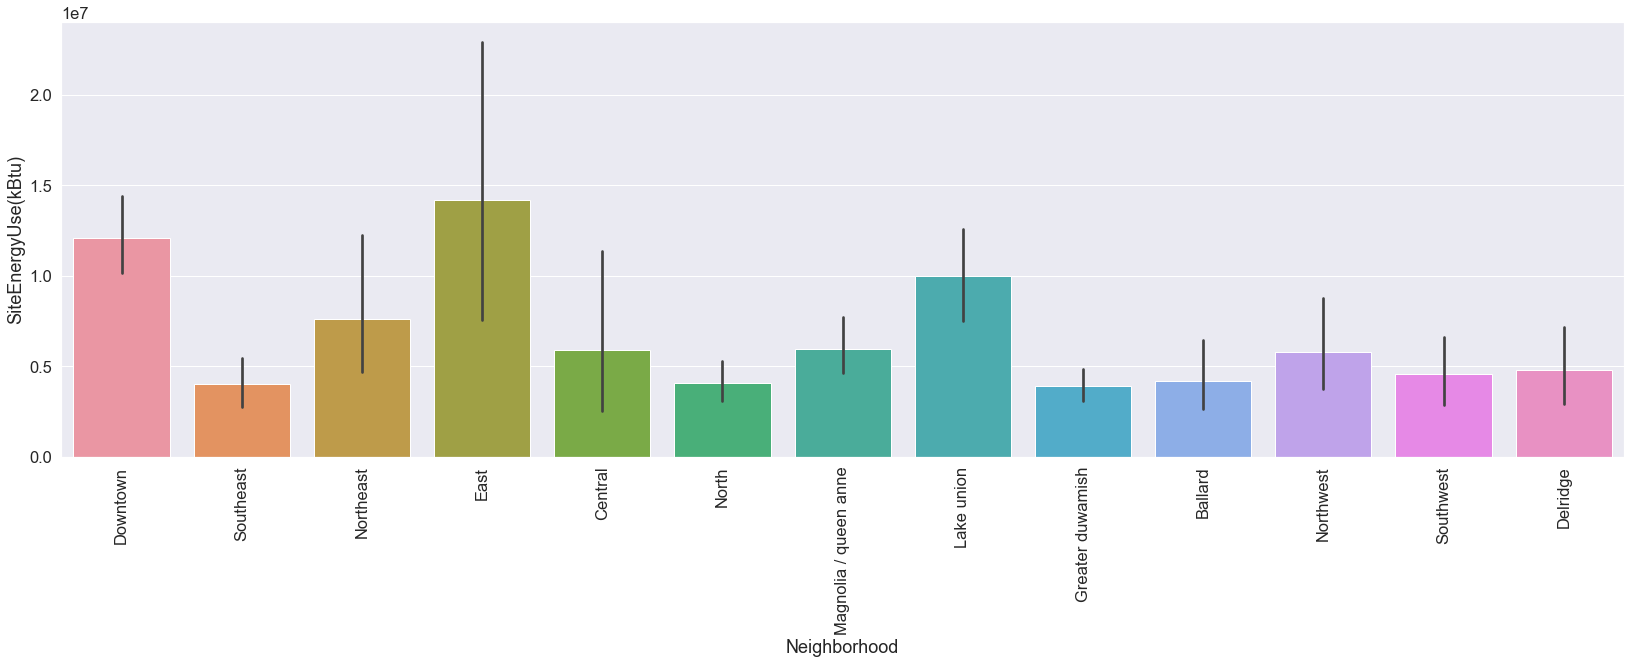

In [62]:
sns.barplot( data=df, y='SiteEnergyUse(kBtu)',x='Neighborhood')
plt.xticks(rotation=90)
plt.show()

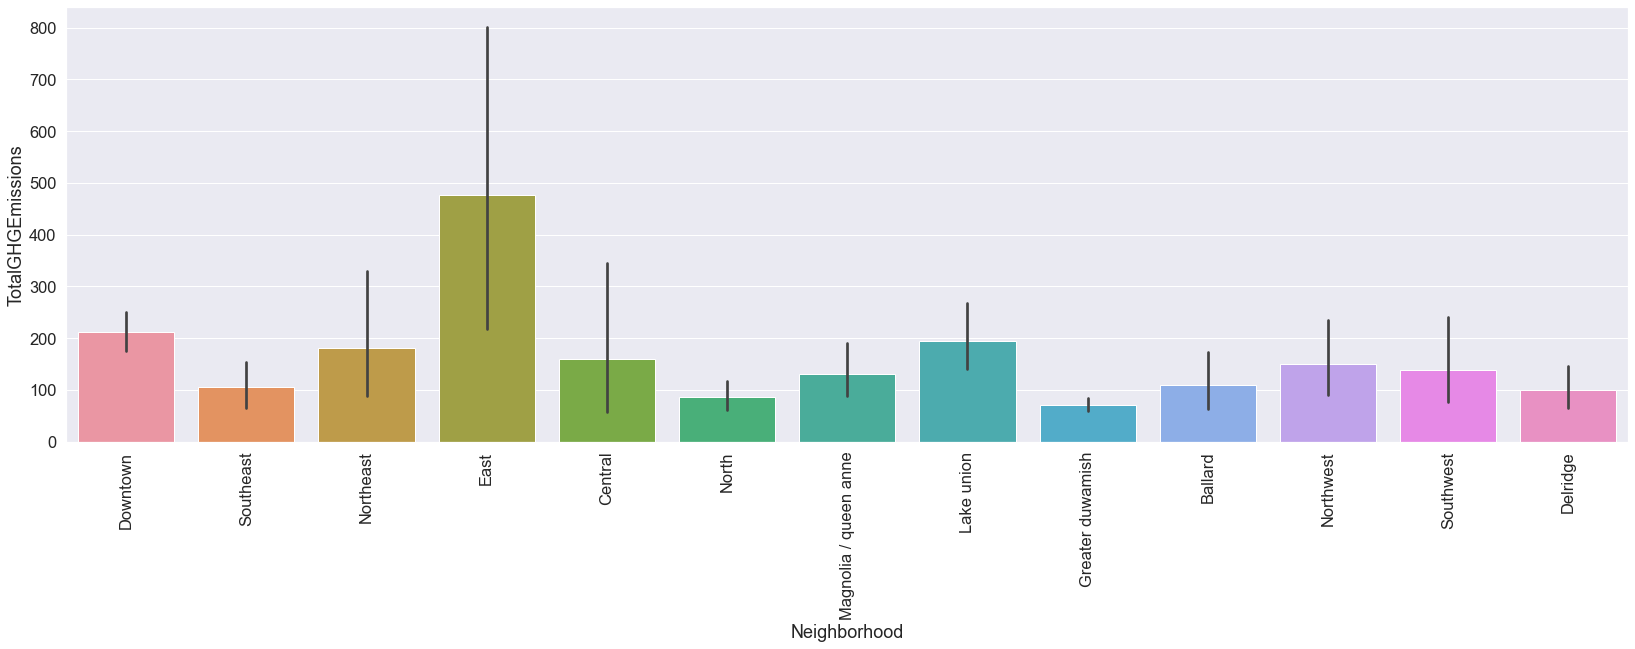

In [63]:
sns.barplot( data=df, y='TotalGHGEmissions',x='Neighborhood')
plt.xticks(rotation=90)
plt.show()

ci-dessus, on remarque que le quartier de l'est consome plus d'energie et genere le plus de co2, de même que le quartier de downtown, on peut donc se posser comme question de quel facon sont distribuer les differents types des battiments.

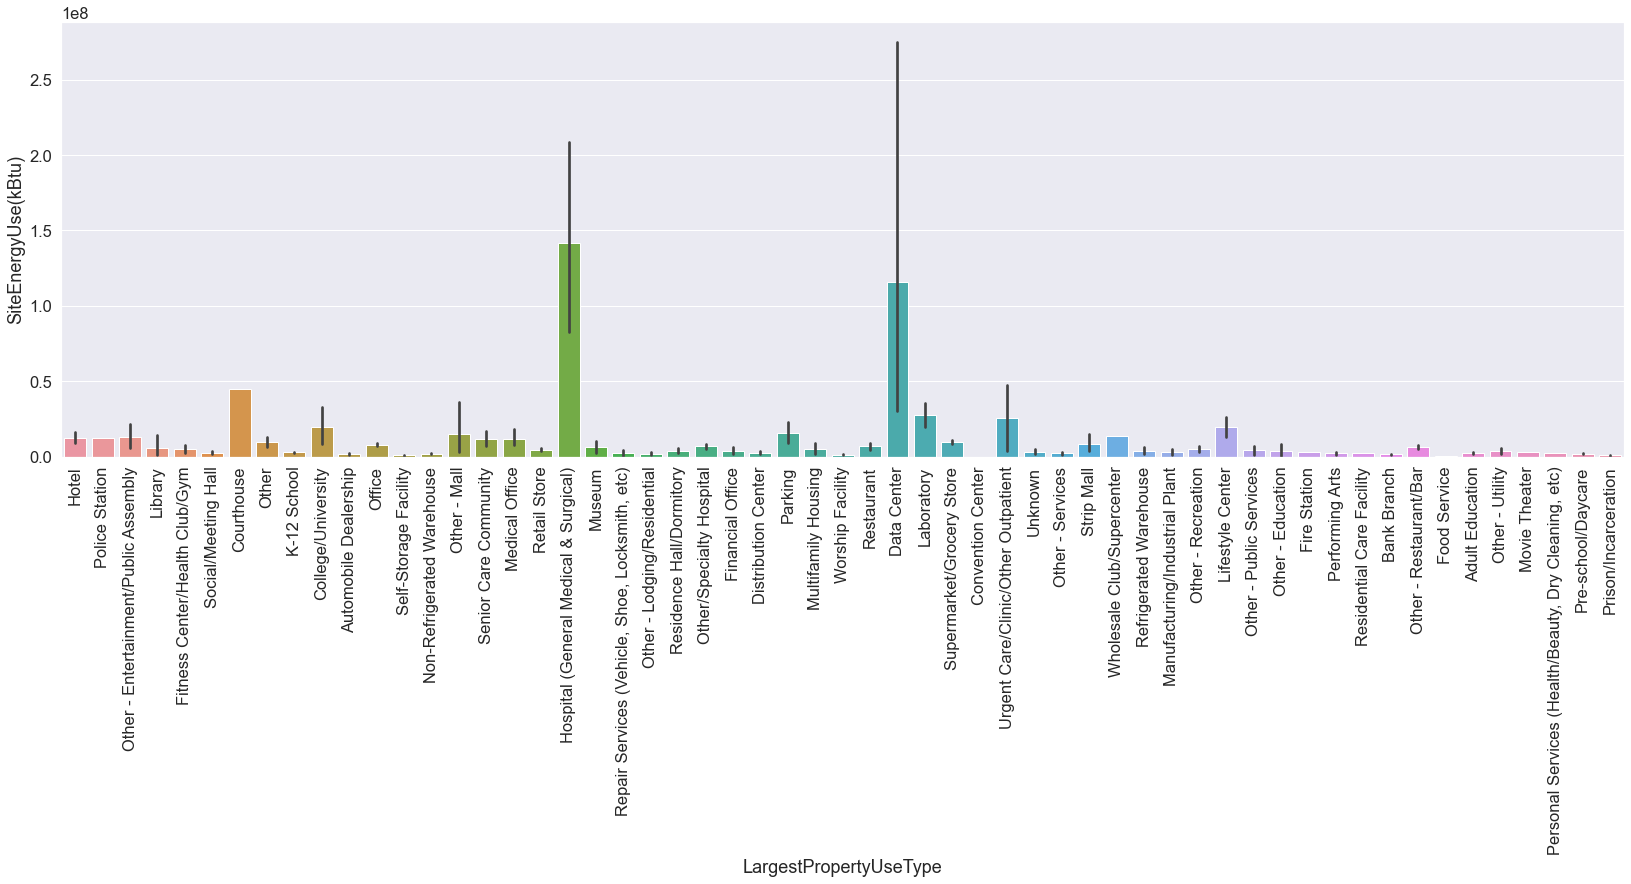

In [64]:
sns.barplot( data=df, y='SiteEnergyUse(kBtu)',x='LargestPropertyUseType')
plt.xticks(rotation=90)
plt.show()

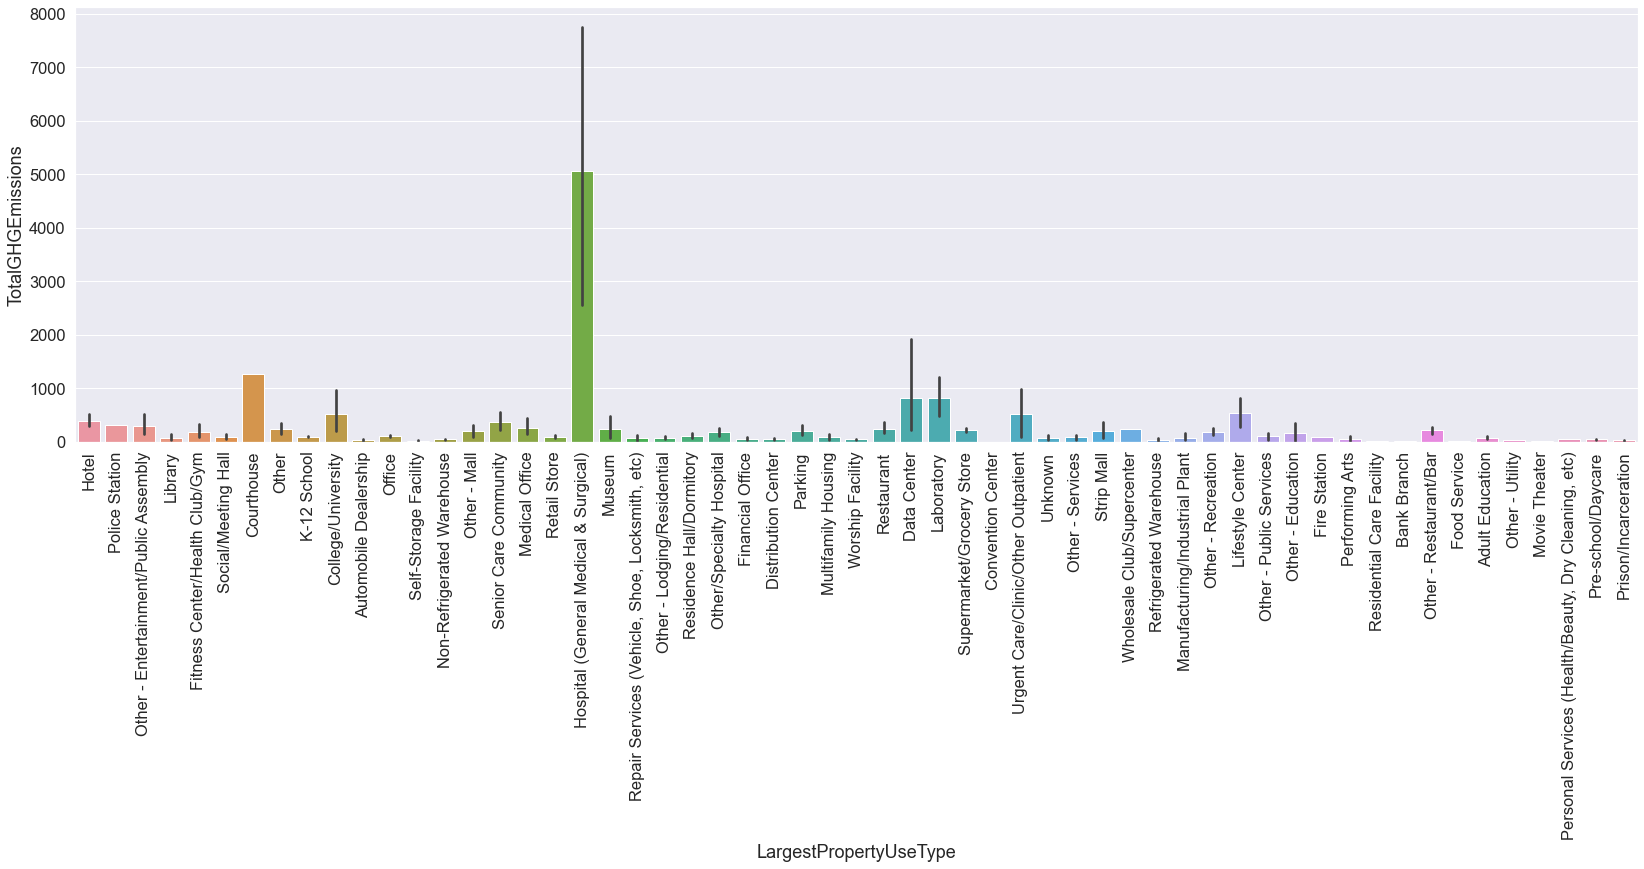

In [65]:
sns.barplot( data=df, y='TotalGHGEmissions',x='LargestPropertyUseType')
plt.xticks(rotation=90)
plt.show()

On observe que les data center et les hopitaux et els tribunaux son ceux qui genere le plus de co2 et consoment le plus d'energie.

In [66]:
types_qualitatives=df.select_dtypes(['int','float'])
labels_qualitatives=types_qualitatives.columns

In [67]:
test=['NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking','PropertyGFABuilding(s)','SteamUse(kBtu)','Electricity(kBtu)']

In [68]:
labels_qualitatives

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'distance', 'BuildingAge'],
      dtype='object')

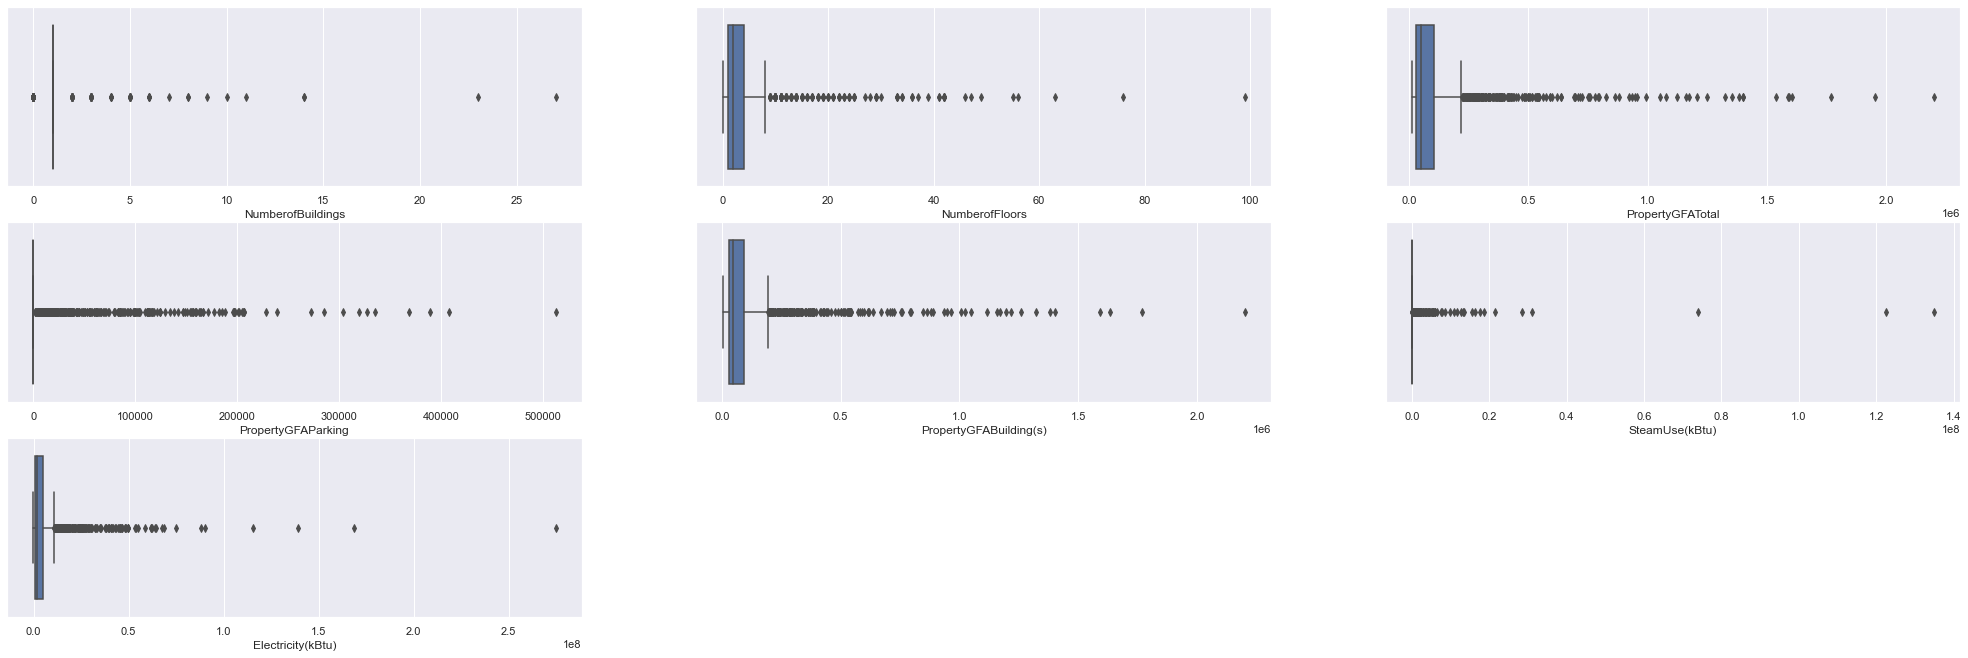

In [93]:
boxplots(types_qualitatives,test)

In [70]:
types_qualitatives.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
NumberofBuildings,1664.0,1.102764e+00,1.159921e+00,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,2.700000e+01
NumberofFloors,1664.0,4.125601e+00,6.570253e+00,0.000000,1.000000e+00,2.000000e+00,4.000000e+00,9.900000e+01
PropertyGFATotal,1664.0,1.131795e+05,1.939116e+05,11285.000000,2.947775e+04,4.926600e+04,1.050708e+05,2.200000e+06
PropertyGFAParking,1664.0,1.292898e+04,4.232058e+04,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,5.126080e+05
PropertyGFABuilding(s),1664.0,1.002506e+05,1.725930e+05,3636.000000,2.847525e+04,4.731650e+04,9.455325e+04,2.200000e+06
LargestPropertyUseTypeGFA,1660.0,9.281309e+04,1.584565e+05,5656.000000,2.551575e+04,4.369450e+04,9.171750e+04,1.719643e+06
ENERGYSTARScore,1093.0,6.550229e+01,2.845286e+01,1.000000,4.800000e+01,7.300000e+01,8.900000e+01,1.000000e+02
SiteEnergyUse(kBtu),1664.0,7.653418e+06,1.866422e+07,0.000000,1.227132e+06,2.552393e+06,6.882718e+06,2.930908e+08
SteamUse(kBtu),1664.0,4.621158e+05,5.113376e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.349435e+08
Electricity(kBtu),1664.0,5.365209e+06,1.285279e+07,-115417.000000,7.208102e+05,1.609992e+06,4.819108e+06,2.745325e+08


On observe, un batiment qui continet 99 etages, on peut donc se demander si c'est un valeur aberrant, ce pour cela qu'on observera plus en profondeur cette valeur ci-dessous.

In [71]:
df[df['NumberofFloors']>80]

,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,distance,BuildingAge,HistoricalPeriod
1359,NonResidential,Worship Facility,Greater duwamish,1.0,99,21948,0,21948,Worship Facility,Worship Facility,21948.0,80.0,326001.1875,0.0,326001.0,0.0,2.27,6.26054,45,Coexistence


In [72]:
coo=(47.55072,-122.30265)
info_build(coo)

Location(Chinese Baptist Church, 5801, Beacon Avenue South, NewHolly, Rainier Valley, Seattle, King County, Washington, 98108, United States, (47.5506041, -122.30303091302457, 0.0))

In [73]:
#valeur aberrant ( apres comparaison des données sur internet , on observe que la valeur n'est pas correct)
df[df['PropertyGFATotal']>2.00000e+06]

,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,distance,BuildingAge,HistoricalPeriod
1494,Campus,University,East,1.0,2,2200000,0,2200000,"College/University, Parking",College/University,1719643.0,NaN,114648520.0,0.0,61672821.0,52975694.0,3243.48,1.230088,83,Crise


In [74]:
coo_1=(47.65644,-122.31041)
info_build(coo_1)

Location(University of Washington, Fuhrman Avenue East, Eastlake, University District, Seattle, King County, Washington, 98015, United States, (47.6543466, -122.30806059473039, 0.0))

In [75]:
df[df['Electricity(kBtu)']<0]

,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,distance,BuildingAge,HistoricalPeriod
3206,NonResidential,Small- and Mid-Sized Office,Central,1.0,6,52000,0,52000,Office,Office,48159.0,100.0,342726.0938,0.0,-115417.0,0.0,-0.8,1.752618,9,actualité


In [76]:
df=df[df['NumberofFloors']<80]
df=df[df['Electricity(kBtu)']>0]

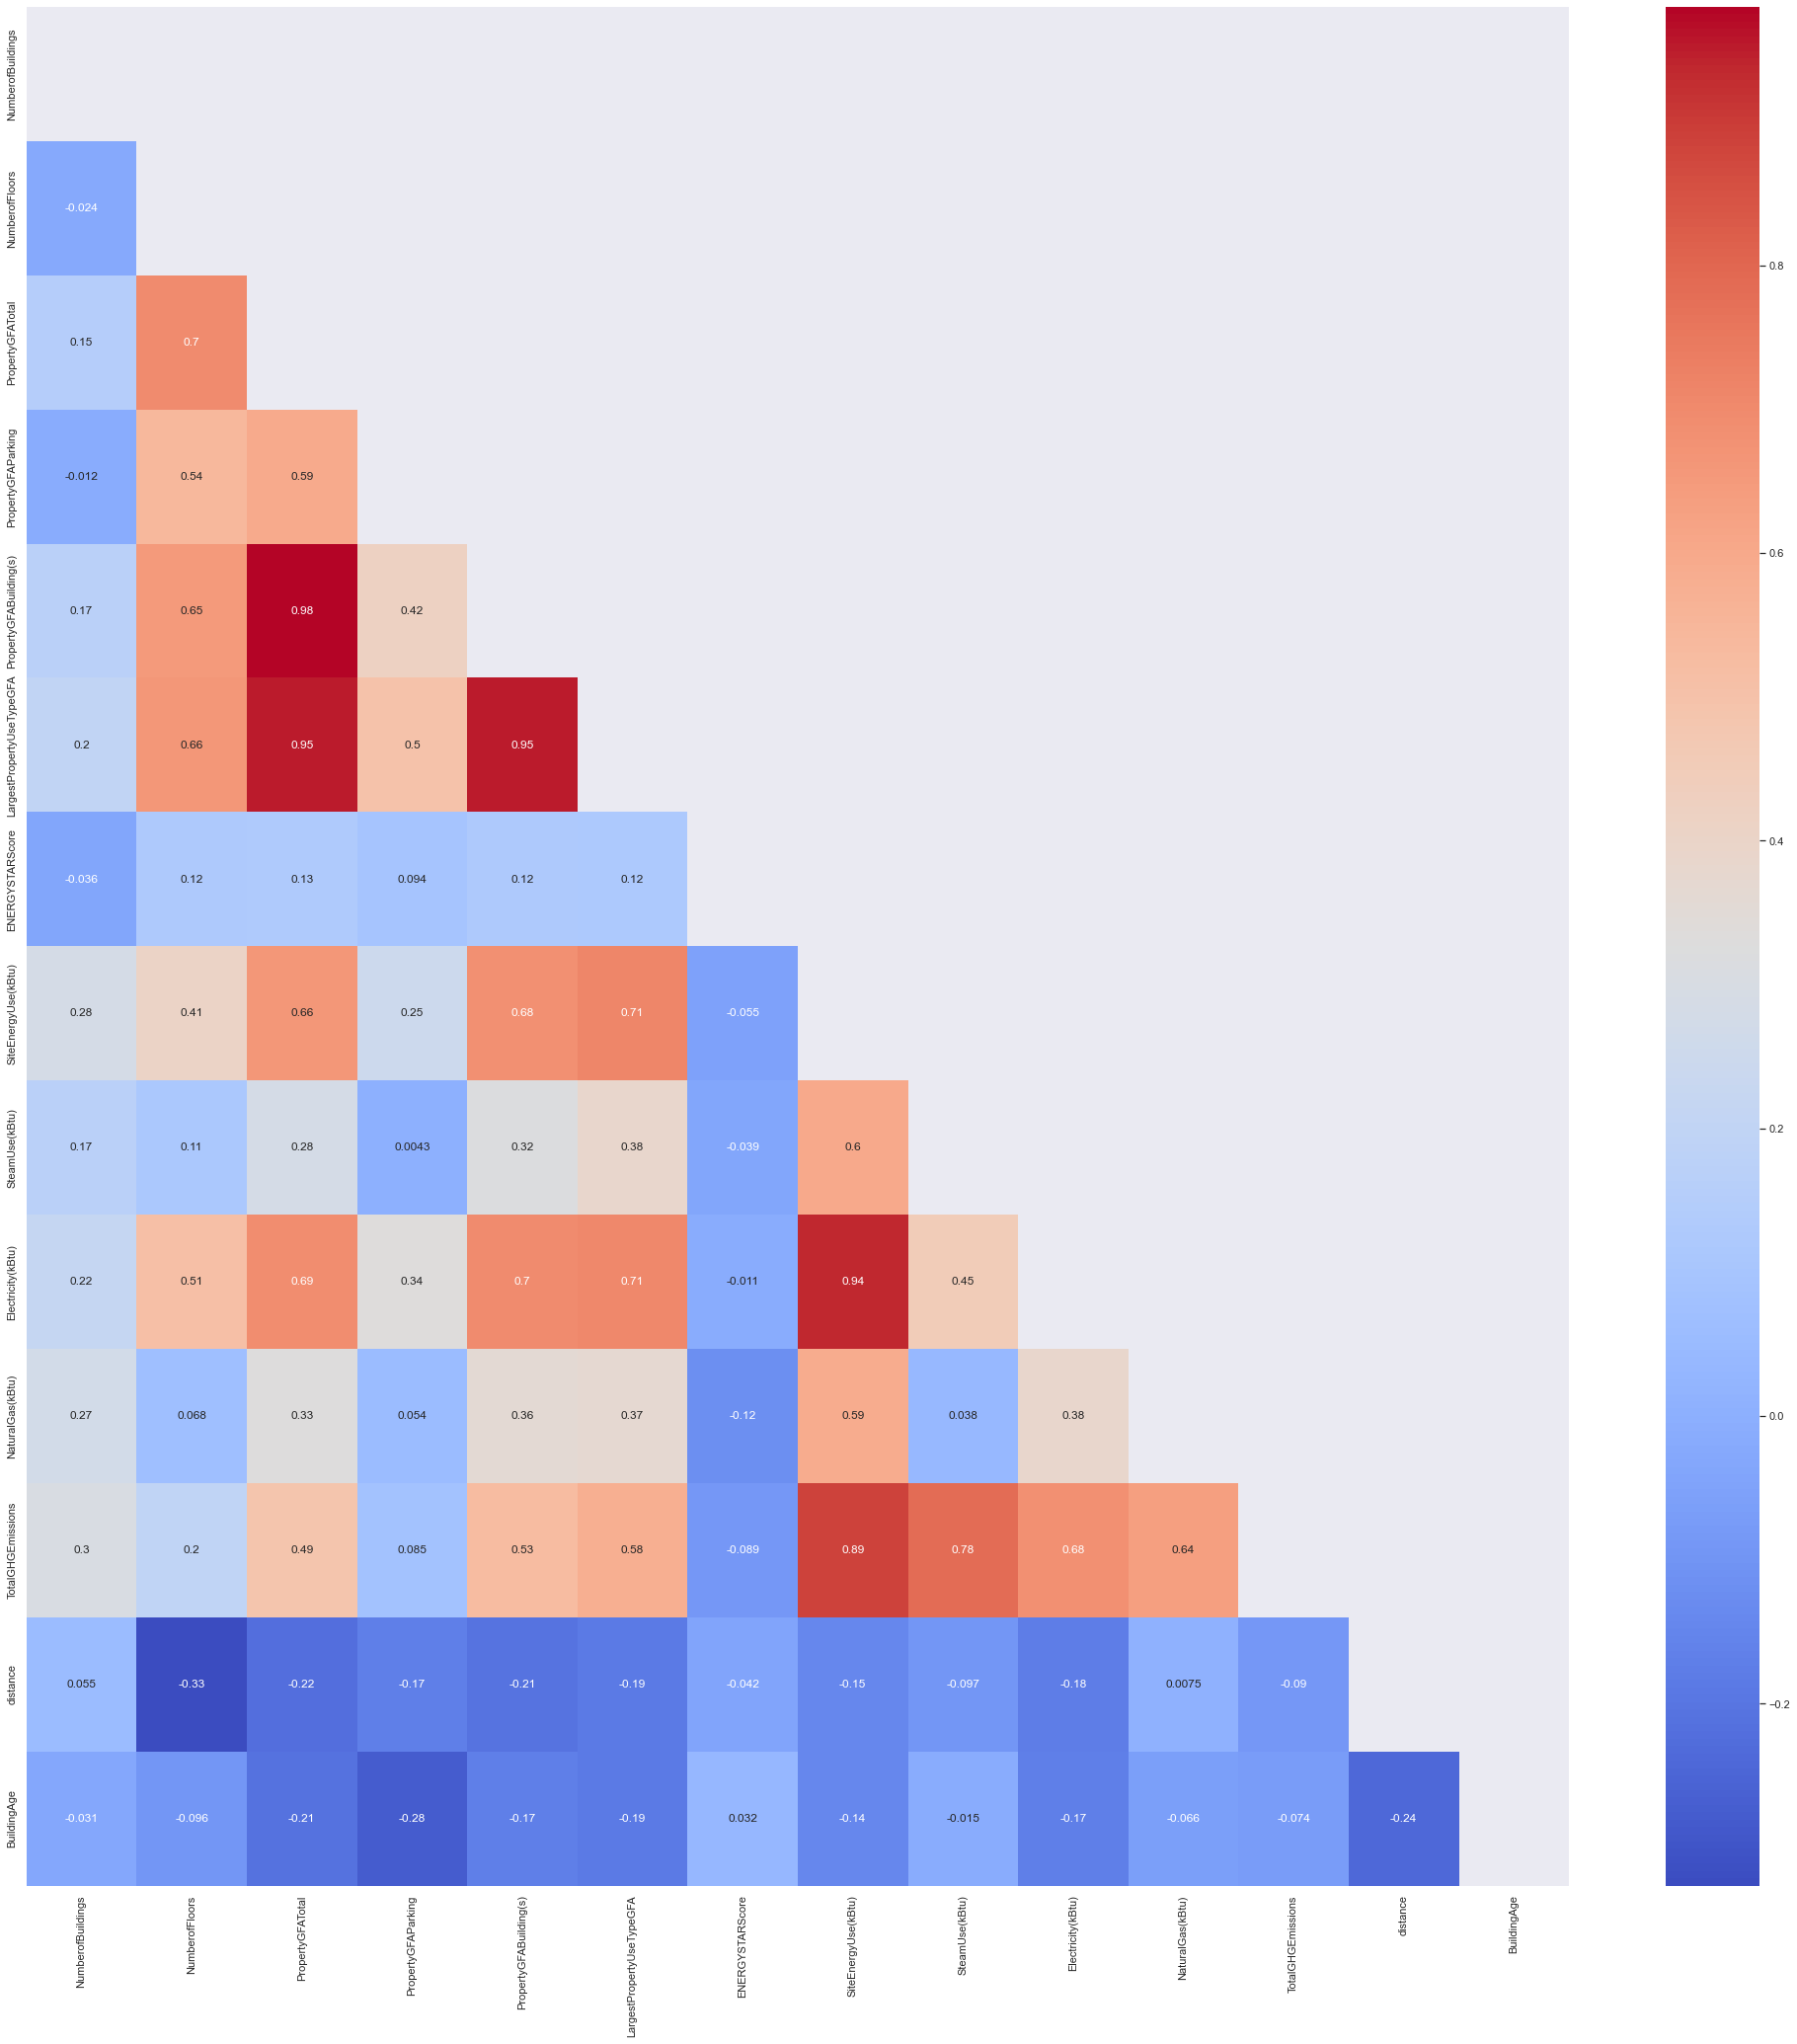

In [77]:
sns.set(rc={'figure.figsize':(35,35)})

df_corr = df.corr()
mask = np.triu(np.ones_like(df_corr, dtype=bool))
ax = sns.heatmap(df_corr, xticklabels = df_corr.columns , yticklabels = df_corr.columns,
                 mask=mask, cmap = 'coolwarm', annot=True)

In [78]:
threshold = 0.7
corr_pairs = df_corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
14,PropertyGFABuilding(s),PropertyGFATotal,0.979662
12,PropertyGFATotal,LargestPropertyUseTypeGFA,0.953116
10,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,0.951355
8,Electricity(kBtu),SiteEnergyUse(kBtu),0.936549
6,TotalGHGEmissions,SiteEnergyUse(kBtu),0.886917
4,SteamUse(kBtu),TotalGHGEmissions,0.783388
2,LargestPropertyUseTypeGFA,SiteEnergyUse(kBtu),0.710539
0,LargestPropertyUseTypeGFA,Electricity(kBtu),0.706582


In [79]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

strong_corr_features = list(set(list(strong_corr['level_0'].values) + list(strong_corr['level_1'].values)))
X = df[strong_corr_features].replace([np.inf, -np.inf], np.nan)
X = X.dropna()

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                   for i in range(len(X.columns))]
vif_data[vif_data['VIF'] > 5]

,feature,VIF
0,SteamUse(kBtu),11.652873
1,PropertyGFATotal,43.519484
2,SiteEnergyUse(kBtu),676.564558
3,LargestPropertyUseTypeGFA,18.991918
4,Electricity(kBtu),250.371100
5,PropertyGFABuilding(s),37.850183
6,TotalGHGEmissions,211.038325


In [80]:
#surface des battiments et parking 
df['LP_Ratio'] = round(df['LargestPropertyUseTypeGFA']/df['PropertyGFATotal'],5)
df['BuildingRate']=round(df['PropertyGFABuilding(s)']/df['PropertyGFATotal'],5)
df['ParkingRate']=round(df['PropertyGFAParking']/df['PropertyGFATotal'],5)
#Surface par battiments et etage
#df['GFAPerBuilding'] = round((df['PropertyGFATotal'] / df['NumberofBuildings'].fillna(1)),3)
#df['GFAPerFloor'] = round((df['PropertyGFATotal'] / df['NumberofFloors']),3)
#on supprime l'aire 
remove_column(df,['PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA'])

In [81]:
df=df[df['LP_Ratio'].notna()]

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1647 entries, 0 to 3375
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   BuildingType               1647 non-null   object  
 1   PrimaryPropertyType        1647 non-null   object  
 2   Neighborhood               1647 non-null   object  
 3   NumberofBuildings          1647 non-null   float64 
 4   NumberofFloors             1647 non-null   int64   
 5   PropertyGFATotal           1647 non-null   int64   
 6   ListOfAllPropertyUseTypes  1647 non-null   object  
 7   LargestPropertyUseType     1647 non-null   object  
 8   ENERGYSTARScore            1087 non-null   float64 
 9   SiteEnergyUse(kBtu)        1647 non-null   float64 
 10  SteamUse(kBtu)             1647 non-null   float64 
 11  Electricity(kBtu)          1647 non-null   float64 
 12  NaturalGas(kBtu)           1647 non-null   float64 
 13  TotalGHGEmissions          1647 n

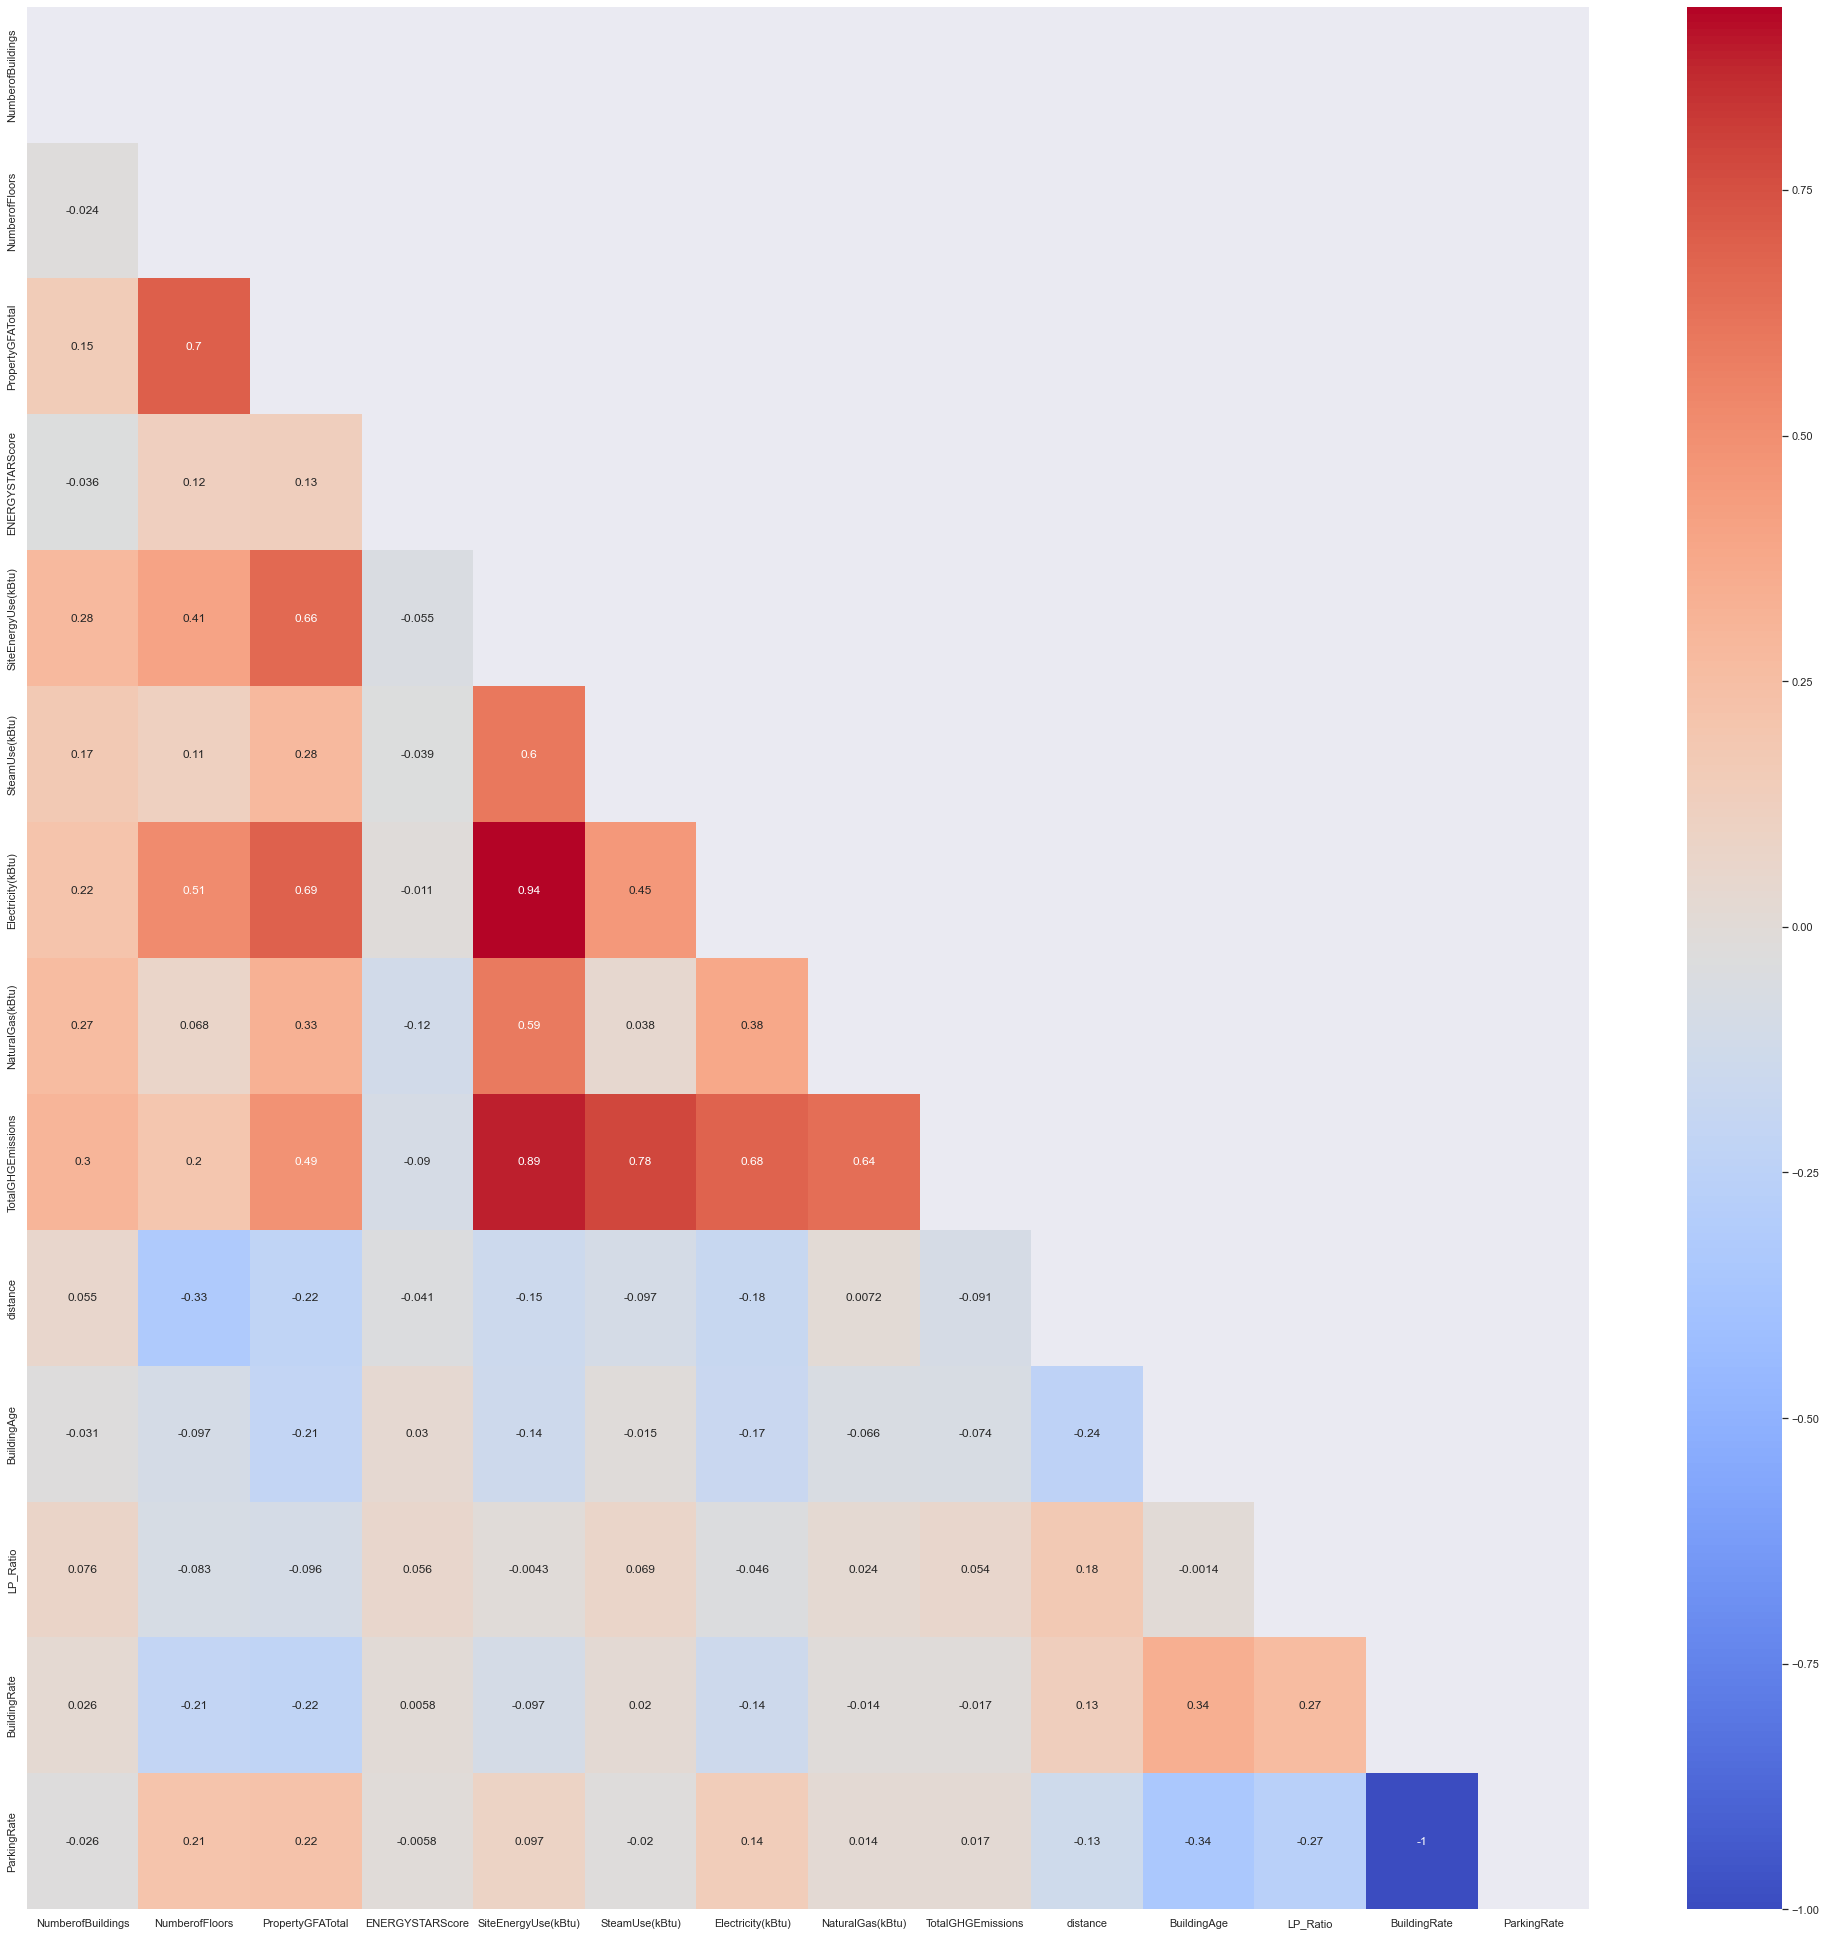

In [83]:
sns.set(rc={'figure.figsize':(35,35)})

df_corr = df.corr()
mask = np.triu(np.ones_like(df_corr, dtype=bool))
ax = sns.heatmap(df_corr, xticklabels = df_corr.columns , yticklabels = df_corr.columns,
                 mask=mask, cmap = 'coolwarm', annot=True)

### Test de distribution 

In [84]:
shapiro_test = stats.shapiro(df['TotalGHGEmissions'])
shapiro_test

ShapiroResult(statistic=0.2235279083251953, pvalue=0.0)

In [85]:
anderson(df['TotalGHGEmissions'])

AndersonResult(statistic=369.5346239921721, critical_values=array([0.575, 0.654, 0.785, 0.916, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

C:\Users\cardn\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='TotalGHGEmissions', ylabel='Density'>

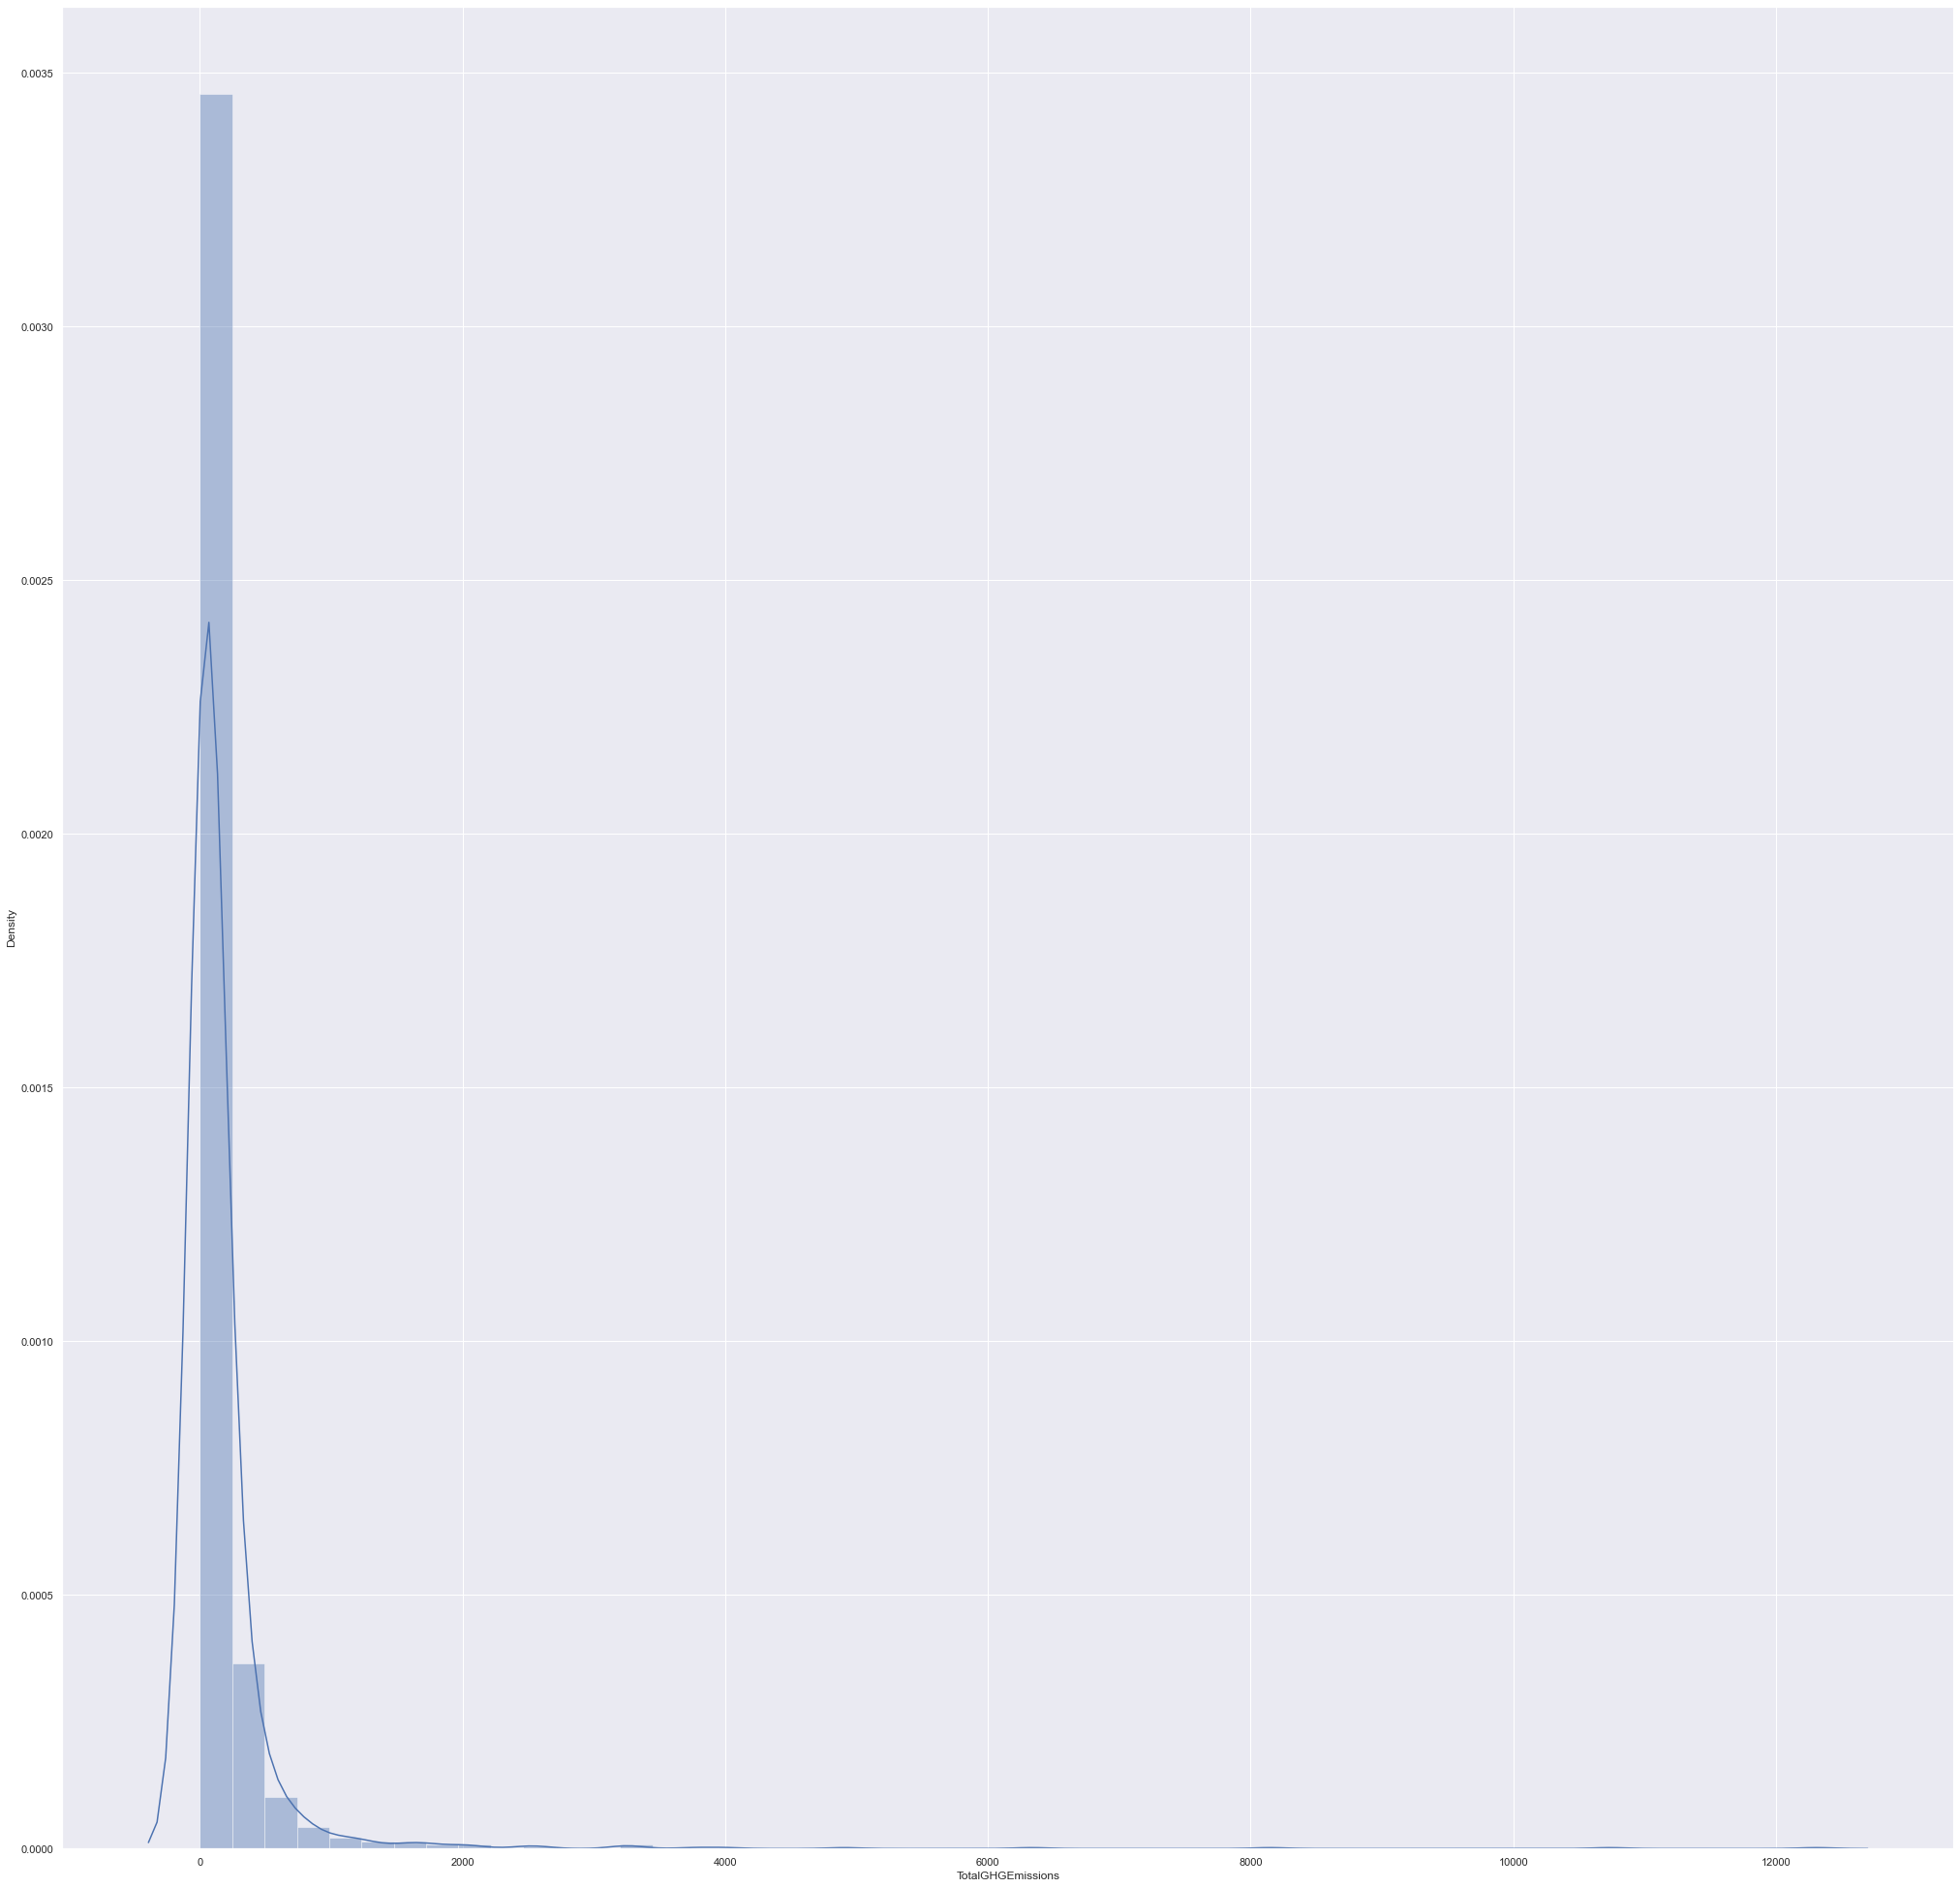

In [86]:
sns.distplot(df['TotalGHGEmissions'])

In [87]:
anderson(df['NaturalGas(kBtu)'])

AndersonResult(statistic=345.39400056872955, critical_values=array([0.575, 0.654, 0.785, 0.916, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [88]:
anderson(df['SiteEnergyUse(kBtu)'])

AndersonResult(statistic=302.17302251875117, critical_values=array([0.575, 0.654, 0.785, 0.916, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

C:\Users\cardn\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SiteEnergyUse(kBtu)', ylabel='Density'>

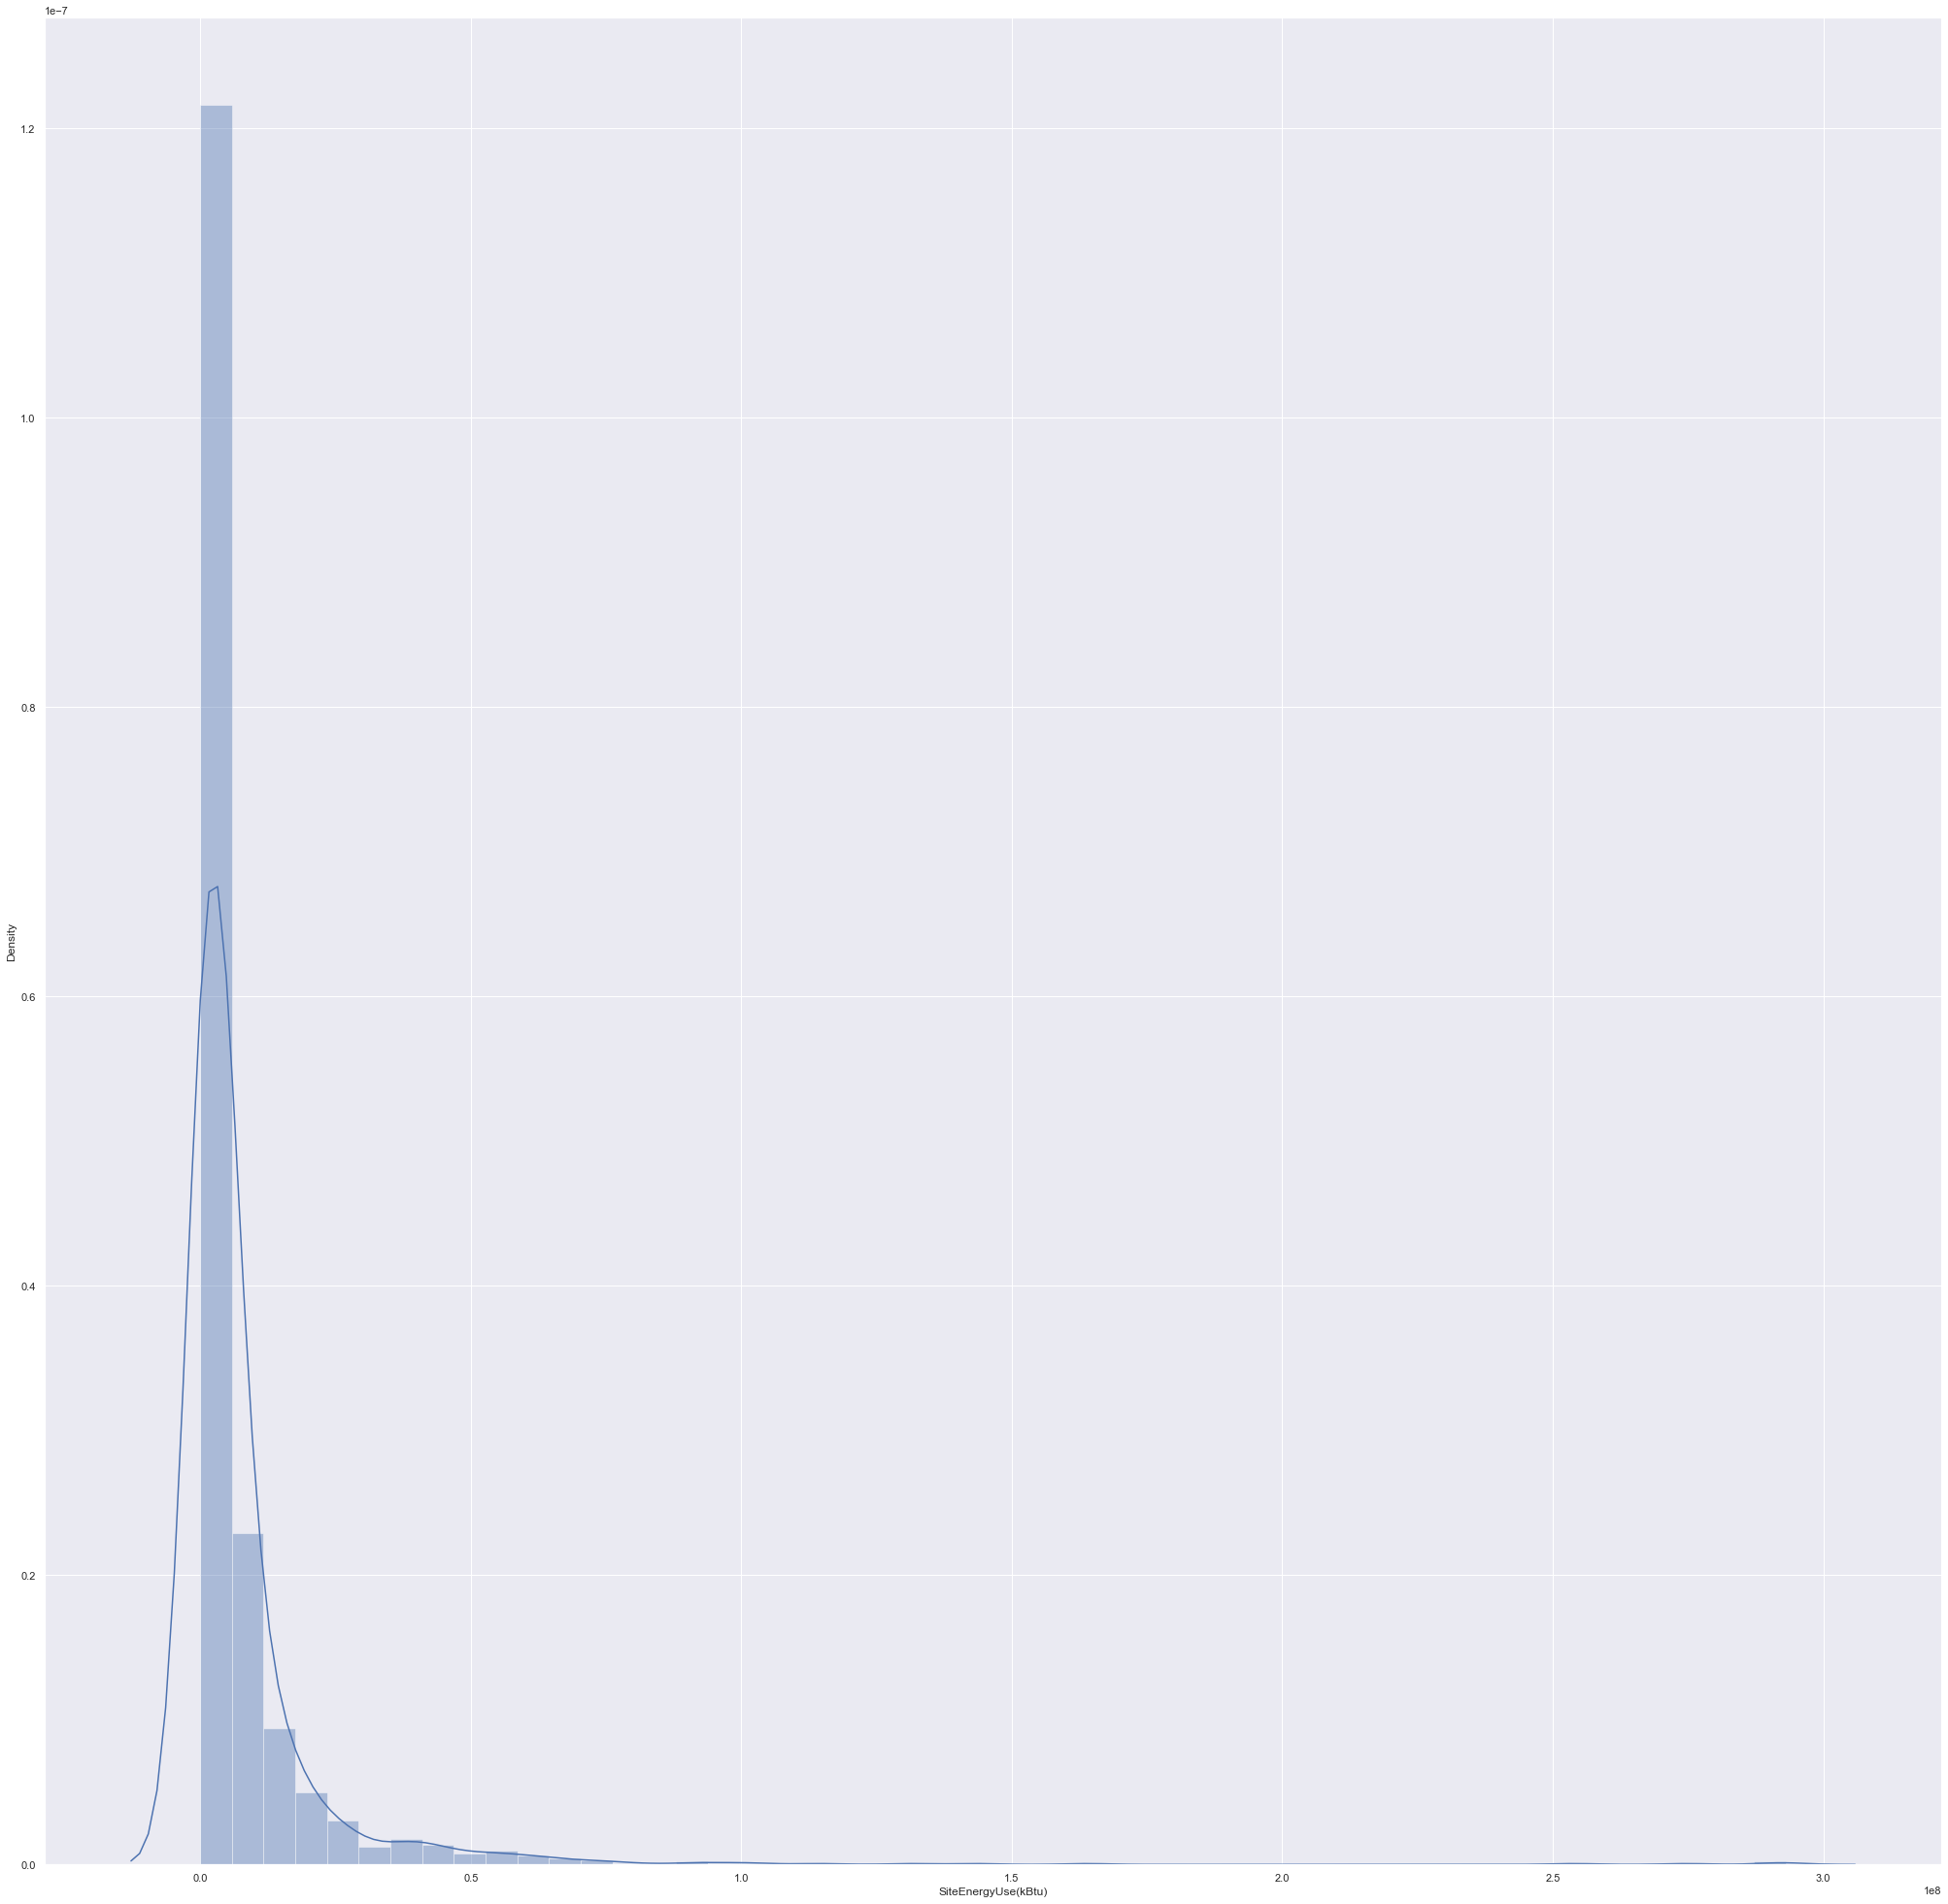

In [89]:
sns.distplot(df['SiteEnergyUse(kBtu)'])

On observe ci-dessus, que la distributions des valeurs est bien de forme normal, on peut donc appliquer de test parametriques afin de determiner la fonctionnalité de nos hypothese.

In [90]:
df=df.rename(columns={'SiteEnergyUse(kBtu)':'SiteEnergyUse','SteamUse(kBtu)':'SteamUse',
                      'Electricity(kBtu)':'Electricity','NaturalGas(kBtu)':'NaturalGas'})

In [91]:
df['TotalUseTypeNumber'] = [str(word).count(",") + 1 for word in df['ListOfAllPropertyUseTypes'].str.split(',')]
df.drop('ListOfAllPropertyUseTypes', axis=1, inplace=True)

In [92]:
df.to_csv("building-energy-cleaned.csv",index=False)